# Задача и предоставленные данные

Необходимо построить модель для предсказания конечной температуры стали в ковше при доводке её до необходимого состава и состояния. 

В ходе производства контролируются и замеряются следующие параметры:
- Используемая в процессе электрическая мощность
- Начальная температура ковша
- Используемые добавки 
- Время технологического процесса
- Конечная температура ковша, как признак, который надо предсказать

## Предоставленные данные


Предоставлены несколько таблиц. Все таблицы имеют одно общее объединяющее поле key, которое является номером отдельной плавки, отдельного ковша. Таблицы содержат следующие данные:
- data_arc -  содержит интервалы нагрева ковша по времени с активной и реактивной мощностью. На каждый key имеется несколько записей.
- data_temp - содержит время и температуру ковша в определенное время. На каждый key имеется несколько записей
- data_gas содержит информацию об обработке ковша газом. На каждый key имеет одну запись
- data_bulk - содержит перечень добавок и их количество по каждому ковшу. На каждый key имеется одна запись
- data_bulk_time  содержит время внесения добавок . На каждый key имеется одна запись.
- data_wire - содержит перечень добавок проволоки. На каждый key имеется одна запись.
- data_wire_time  содержит время внесения проволоки . На каждый key имеется одна запись.

Для работы с моделью нам необходимо будет создать таблицу, в которой будут содержаться следующие поля:
- конечная температура из data_temp как целевой признак
- Начальная температура из data_temp
- Данные по затратам энергии из data_arc
- Количество добавок из data_bulk и data_wire. Если в исходных таблицах нет данных по какой либо из добавки, то принимаем её равной нолю.

### План работы

#### План работы:  
- Провести исследовательский анализ данных:
    - Посмотреть на распределение исходных данных, решить вопросы, связанные с некорректностью данных(пропуски, выбросы)
    - Проанализировать порядок событий в производственном процессе
    - Исключить партии, которые не имеют последнего замера темпиратуры, либо первый замер соответствует последнему, либо замеры отсутствуют 
    - Оставить только события, которые находятся в промежутке между первым и последним замерами
- Подобрать признаки, на которых будет обучаться модель:
    - Сгенерировать ряд признаков
    - Проверить признаки на мультиколлинеарность, исключить лишние
    - Провести масштабирование признаков
- Построить модель, которая предскажет температуру стали:
    - Сформировать обучающую, валидационную и тестовую выборки
    - Выбрать несколько моделей и проверить их эффективность на валидационной выборке с помощью показателя эффективности MAE
    - Эффективность лучшей модели проверить на тестовой выборке





### Подготовка данных, предварительный анализ

На основании представленных данных, можно сделать вывод, что из семи таблиц нам необходимо будет создать одну, которая и будет использоваться для обучения модели.  Для создания такой таблицы необходимо будет создать код, который проверит следующие параметры:
- После замера последней температуры по ковшу из файла data_temp,  с ковшом не производилось никаких действий, то есть в таблицах data_bulk_time , data_wire_time и data_arc нет никаких действий по времени позже , чем последнее время замера. Если такое есть, то такой ковш не входит в данные для моделирования.
- Проверить на аномалии параметры по энергетике, газу, начальной и конечной температуре. По результатам найденых аномалий принимать решение, что с ними делать.

Необходимо отметить и учесть некоторые замеченные при первичном осмотре данных особенности:
- Энергетика. На процесс влияет только активная мощность, реактивная мощность - это больше о потерях в сети. Для нас интересно количества тепла, использованного для технологического процесса. Таким образом, нам для каждого ковша надо будет найти произведение активной энергии на время нагрева. Так как циклов в каждом процессе несколько, надо будет сложить произведения и использовать результат в качестве признака. 
- Если добавок wire  или bulk  не производилось, то строка с этим key отсутствует в данных и по содержанию добавок, и по времени. Необходимо учитывать, чтобы программа корректно отработала пропуски этих строк.



# Исследовательский анализ данных

## Скачивание и предварительный просмотр

Считаем данные, не утруждая себя в названиях таблиц: таблицы будут называться также, ка и исходные файлы.

In [202]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import warnings 
import unicodedata 
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor  
from statsmodels.tools.tools import add_constant

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from catboost import Pool

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb


In [203]:
# Читаем все данные
data_arc = pd.read_csv('~/Downloads/final_steel/data_arc.csv' )
data_gas = pd.read_csv('~/Downloads/final_steel/data_gas.csv' )
data_temp = pd.read_csv('~/Downloads/final_steel/data_temp.csv' )
data_bulk = pd.read_csv('~/Downloads/final_steel/data_bulk.csv' )
data_bulk_time = pd.read_csv('~/Downloads/final_steel/data_bulk_time.csv' )
data_wire = pd.read_csv('~/Downloads/final_steel/data_wire.csv' )
data_wire_time = pd.read_csv('~/Downloads/final_steel/data_wire_time.csv' )

Смотрим данные по энергетике

In [204]:
display(data_arc.head(10))
data_arc.info()
print('Минимальное значение индекса key ', data_arc['key'].min())
print('Максимальное значение индекса key ', data_arc['key'].max())

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
Минимальное значение индекса key  1
Максимальное значение индекса key  3241


Смотрим данные по газу

In [205]:
data_gas.set_axis(['key', 'gas'], axis=1, inplace=True) 
display(data_gas.head(10))
data_gas.info()
print('Минимальное значение индекса key ', data_gas['key'].min())
print('Максимальное значение индекса key ', data_gas['key'].max())


,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
Минимальное значение индекса key  1
Максимальное значение индекса key  3241


Смотрим данные по температуре

In [206]:
display(data_temp.head(10))
data_temp.info()
print('Минимальное значение индекса key ', data_temp['key'].min())
print('Максимальное значение индекса key ', data_temp['key'].max())

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB
Минимальное значение индекса key  1
Максимальное значение индекса key  3241


Смотрим данные по bulk

In [207]:
display(data_bulk.head(10))
data_bulk.info()
print('Минимальное значение индекса key ', data_bulk['key'].min())
print('Максимальное значение индекса key ', data_bulk['key'].max())

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
Минимальное значение индекса key  1
Максимальное значение индекса key  3241


In [208]:
display(data_bulk_time.head(10))
data_bulk_time.info()
print('Минимальное значение индекса key ', data_bulk_time['key'].min())
print('Максимальное значение индекса key ', data_bulk_time['key'].max())

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,NaN,NaN,NaN,2019-05-03 13:59:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:53:27,NaN,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,NaN,NaN,NaN,2019-05-03 14:29:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:22:19,NaN,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,NaN,NaN,NaN,2019-05-03 15:04:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:55:46,NaN,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,NaN,NaN,NaN,2019-05-03 15:47:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:41:00,NaN,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:18:52,NaN,2019-05-03 16:18:52,2019-05-03 16:18:52


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
Минимальное значение индекса key  1
Максимальное значение индекса key  3241


Сморим данные по wire

In [209]:
display(data_wire.head(10))
data_wire.info()
print('Минимальное значение индекса key ', data_wire['key'].min())
print('Максимальное значение индекса key ', data_wire['key'].max())

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
Минимальное значение индекса key  1
Максимальное значение индекса key  3241


In [210]:
display(data_wire_time.head(10))
data_wire_time.info()
print('Минимальное значение индекса key ', data_wire_time['key'].min())
print('Максимальное значение индекса key ', data_wire_time['key'].max())

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:28:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:03:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:42:43,2019-05-03 15:58:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:20:25,2019-05-03 16:21:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
Минимальное значение индекса key  1
Максимальное значение индекса key  3241


### Выводы по первичному анализу данных

Из того, что видно по первчному просмотру, можно сделать вывод сразу же: на индекс key опираться не стоит. Его пропуски есть во всех таблицах. 

Теоретически мы имеем 3241 плавку. По факту необходимо будет обязательно контролировать следующие параметры:
- если индекса key не окажется в таблице data_temp, то эту плавку необходимо будет выкинуть из итогов, так как без целевого признака мы не можем работать.
- если индекса key не окажется в data_arc, то эту плавку тоже надо будет выкинуть. Это какая-то аномалия, не может быть плавки без нагрева
- если индекса key не окажется в data_gas, то это означает, что газа в этой плавке не добавляли и на место газа надо будет поставить 0
- если индекса key не окажется таблицах data_wire или data_bulk, то это означает, что соответствующих добавок не было и в соответсвующую строку надо будет поставить нулевые значения.

Что касается контроля времени. Нам необходимо соблюсти условие, что после последнего замера температуры не должно производится никаких действий. Потому по каждому key необходимо будет сравнить время последнего замера температуры со следующим списком времен: "Конец нагрева дугой", максимальным временем из соответствующей строки таблицы data_bulk_time и data_wire_time. Если хотя бы одно из них окажется больше последнего времени замера температуры, такая строка key должна быть удалена.

В таблицах data_bulk и data_wire необходимо будет отсутствующие значения заменить на ноли. Это логично, просто соответствующих добавок не было сделано.

По итогам такого анализа и замен необходимо будет сформировать таблицу, содержащую следующие столбцы:
- конечная температура
- начальная температура
- энергетические затраты
- использованние газа
- 15 колонок по содержанию bulk
- 9 колонок по содержанию wire

После формирования такой таблицы, будет сделан анализ ее на аномалии и выбросы.

## Формирование таблицы данных

Мы имеем два вида таблиц данных:
- имеют только одну строку с данными на каждый key. Это data_gas, data_bulk, data_bulk_time, data_wire, data_wire_time
- имеют несколько строк со значениями key: data_arc, data_temp

Создадим пять таблиц, содержащих информацию по энергетике, газу, температуре, bulk и wire. Каждая таблица будет иметь полный набор строк со значением key от 1 до 3241. Полями будут данные, необходимы нам для дальнейшего анализа.

### Таблица по энергетике

В эту таблицу включим следующие параметры: key, время завершения последнего нагрева, сумму произведения мощности на время.

In [211]:
# преобразуем формат времени
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'])
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])
# введем столбец затраченной при этой плавке энергии
data_arc['Энергия'] = (data_arc['Конец нагрева дугой'] - 
                data_arc['Начало нагрева дугой']).dt.seconds.astype('float64') * data_arc['Активная мощность']


Организуем новую таблицу, в которой будет поле key, сумма затраченной энергии по этой плавке и максимальное время конца нагрева.

In [212]:
data_arc_new = pd.pivot_table(data_arc,
                             index = 'key',
                             values = ['Энергия', 'Конец нагрева дугой'],
                             aggfunc = [sum, max])

data_arc_new.set_axis(['energy', 'last_time', 'enr'], axis=1, inplace=True)
data_arc_new.drop(['enr'], axis = 1, inplace=True)
data_arc_new['key'] = data_arc_new.index
data_arc_new.index.name = None
display(data_arc_new)
data_arc_new.info()



,energy,last_time,key
1,1207.804249,2019-05-03 11:28:37,1
2,733.816470,2019-05-03 11:53:18,2
3,443.583327,2019-05-03 12:32:19,3
4,670.663327,2019-05-03 12:57:50,4
5,997.496095,2019-05-03 13:33:55,5
...,...,...,...
3237,777.993447,2019-08-31 23:03:48,3237
3238,432.849310,2019-08-31 23:41:28,3238
3239,844.977151,2019-09-01 02:15:43,3239
3240,554.283211,2019-09-01 03:34:08,3240


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 1 to 3241
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   energy     3214 non-null   float64       
 1   last_time  3214 non-null   datetime64[ns]
 2   key        3214 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 100.4 KB


Что оказалось интересно, количество записей не полное, то есть не по всем плавкам имеется информация о затратах энергии.

### Таблица по температурам

In [213]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'])  # преобразуем время
display(data_temp)
data_temp.info()
print('Минимальное значение индекса key ', data_temp['key'].min())
print('Максимальное значение индекса key ', data_temp['key'].max())

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           15907 non-null  int64         
 1   Время замера  15907 non-null  datetime64[ns]
 2   Температура   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB
Минимальное значение индекса key  1
Максимальное значение индекса key  3241


In [214]:
# выберем максимальное значение времени по ключу и измеренную при этом температуру
data_temp_new = (data_temp.loc[data_temp.groupby('key')['Время замера'].idxmax()])

data_temp_new.set_axis(['key', 'time_temp', 'temp'], axis=1, inplace=True)
display(data_temp_new)
data_temp_new.info()

,key,time_temp,temp
4,1,2019-05-03 11:30:39,1613.0
10,2,2019-05-03 11:59:12,1602.0
15,3,2019-05-03 12:34:57,1599.0
18,4,2019-05-03 12:59:25,1625.0
20,5,2019-05-03 13:36:01,1602.0
...,...,...,...
15882,3237,2019-08-31 23:05:43,NaN
15885,3238,2019-08-31 23:43:00,NaN
15893,3239,2019-09-01 02:24:15,NaN
15901,3240,2019-09-01 03:35:16,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 4 to 15906
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   key        3216 non-null   int64         
 1   time_temp  3216 non-null   datetime64[ns]
 2   temp       2477 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 100.5 KB


In [215]:
data_temp_init = (data_temp.loc[data_temp.groupby('key')['Время замера'].idxmin()])

data_temp_init.drop('Время замера',axis=1, inplace=True)
data_temp_init.set_axis(['key',  'temp_init'], axis=1, inplace=True)
display(data_temp_init.head(5))
data_temp_init.info()

,key,temp_init
0,1,1571.0
5,2,1581.0
11,3,1596.0
16,4,1601.0
19,5,1576.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 15902
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   key        3216 non-null   int64  
 1   temp_init  3216 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 75.4 KB


Видно, что в колонке температур имеются пустые значения. С ним разберемся при соединении таблиц.


Теперь массивы с данными по bulk. В обоих массивах надо заполнить пустые значения, в массиве date_bulk_time привести данные в формат времени. Затем в каждой строке массива date_bulk_time выбрать наибольшее время и перенести его в соответствующую строку массива date_bulk

### Таблица по добавким bulk

In [216]:
data_bulk = data_bulk.fillna(0)  # заменим пустые значения на ноль
display(data_bulk)
data_bulk.info()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0
3125,3238,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0
3126,3239,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0
3127,3240,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   3129 non-null   float64
 2   Bulk 2   3129 non-null   float64
 3   Bulk 3   3129 non-null   float64
 4   Bulk 4   3129 non-null   float64
 5   Bulk 5   3129 non-null   float64
 6   Bulk 6   3129 non-null   float64
 7   Bulk 7   3129 non-null   float64
 8   Bulk 8   3129 non-null   float64
 9   Bulk 9   3129 non-null   float64
 10  Bulk 10  3129 non-null   float64
 11  Bulk 11  3129 non-null   float64
 12  Bulk 12  3129 non-null   float64
 13  Bulk 13  3129 non-null   float64
 14  Bulk 14  3129 non-null   float64
 15  Bulk 15  3129 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [217]:
data_bulk_time1 = data_bulk_time.fillna('2019-01-01 12:00:00')

# не удалось выполнить групповую операцию. Пришлось повторить ее 15 раз

data_bulk_time1['Bulk 1'] = pd.to_datetime(data_bulk_time1['Bulk 1'])
data_bulk_time1['Bulk 2'] = pd.to_datetime(data_bulk_time1['Bulk 2'])
data_bulk_time1['Bulk 3'] = pd.to_datetime(data_bulk_time1['Bulk 3'])
data_bulk_time1['Bulk 4'] = pd.to_datetime(data_bulk_time1['Bulk 4'])
data_bulk_time1['Bulk 5'] = pd.to_datetime(data_bulk_time1['Bulk 5'])
data_bulk_time1['Bulk 6'] = pd.to_datetime(data_bulk_time1['Bulk 6'])
data_bulk_time1['Bulk 7'] = pd.to_datetime(data_bulk_time1['Bulk 7'])
data_bulk_time1['Bulk 8'] = pd.to_datetime(data_bulk_time1['Bulk 8'])
data_bulk_time1['Bulk 9'] = pd.to_datetime(data_bulk_time1['Bulk 9'])
data_bulk_time1['Bulk 10'] = pd.to_datetime(data_bulk_time1['Bulk 10'])
data_bulk_time1['Bulk 11'] = pd.to_datetime(data_bulk_time1['Bulk 11'])
data_bulk_time1['Bulk 12'] = pd.to_datetime(data_bulk_time1['Bulk 11'])
data_bulk_time1['Bulk 13'] = pd.to_datetime(data_bulk_time1['Bulk 13'])
data_bulk_time1['Bulk 14'] = pd.to_datetime(data_bulk_time1['Bulk 14'])
data_bulk_time1['Bulk 15'] = pd.to_datetime(data_bulk_time1['Bulk 15'])

display(data_bulk_time1)
data_bulk_time1.info()



,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-05-03 11:21:30,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-05-03 11:46:38,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-05-03 12:31:06,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-05-03 12:48:43,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-05-03 13:18:50,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-05-03 13:12:56,2019-05-03 13:12:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-08-31 22:51:28,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-08-31 23:39:11,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-09-01 01:51:58,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-09-01 03:12:40,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-01-01 12:00:00,2019-09-01 02:41:27,2019-09-01 02:41:27


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   3129 non-null   datetime64[ns]
 2   Bulk 2   3129 non-null   datetime64[ns]
 3   Bulk 3   3129 non-null   datetime64[ns]
 4   Bulk 4   3129 non-null   datetime64[ns]
 5   Bulk 5   3129 non-null   datetime64[ns]
 6   Bulk 6   3129 non-null   datetime64[ns]
 7   Bulk 7   3129 non-null   datetime64[ns]
 8   Bulk 8   3129 non-null   datetime64[ns]
 9   Bulk 9   3129 non-null   datetime64[ns]
 10  Bulk 10  3129 non-null   datetime64[ns]
 11  Bulk 11  3129 non-null   datetime64[ns]
 12  Bulk 12  3129 non-null   datetime64[ns]
 13  Bulk 13  3129 non-null   datetime64[ns]
 14  Bulk 14  3129 non-null   datetime64[ns]
 15  Bulk 15  3129 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


In [218]:
# внесем максимальное значение времени по ключу в таблицу data_bulk
data_bulk['max_time_bulk'] = data_bulk_time1.drop('key', axis = 1).max(axis = 1)

display(data_bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,max_time_bulk
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,2019-05-03 11:21:30
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,2019-05-03 11:46:38
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,2019-05-03 12:31:06
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,2019-05-03 12:48:43
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,2019-05-03 13:18:50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0,2019-08-31 22:51:28
3125,3238,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0,2019-08-31 23:39:11
3126,3239,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0,2019-09-01 01:51:58
3127,3240,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0,2019-09-01 03:12:40


### Таблица  по добавкам wire

Теперь аналогично по wire:
1. Заполняем пустые значения в data_wire  нолями
2. В массиве data_wire_time вместо пропусков ставим время раньше всех процессов
3. Переводим времена в формат времени
4. По каждой строке data_wire_time выбираем максимальное время и переносим его в таблицу data_wire



In [219]:
data_wire = data_wire.fillna(0)   # заменяем пропуски на ноли
data_wire_time1 = data_wire_time.fillna('2019-01-01 12:00:00')  #заменяем пропуски на дату

data_wire_time1['Wire 1'] = pd.to_datetime(data_wire_time1['Wire 1']) # преобразовываем в формат даты
data_wire_time1['Wire 2'] = pd.to_datetime(data_wire_time1['Wire 2'])
data_wire_time1['Wire 3'] = pd.to_datetime(data_wire_time1['Wire 3'])
data_wire_time1['Wire 4'] = pd.to_datetime(data_wire_time1['Wire 4'])
data_wire_time1['Wire 5'] = pd.to_datetime(data_wire_time1['Wire 5'])
data_wire_time1['Wire 6'] = pd.to_datetime(data_wire_time1['Wire 6'])
data_wire_time1['Wire 7'] = pd.to_datetime(data_wire_time1['Wire 7'])
data_wire_time1['Wire 8'] = pd.to_datetime(data_wire_time1['Wire 8'])
data_wire_time1['Wire 9'] = pd.to_datetime(data_wire_time1['Wire 9'])


data_wire['max_time_wire'] = data_wire_time1.drop('key', axis = 1).max(axis = 1)  # находим максимальное время 
                                                                              # и переносим его в массив data_wire

    
display(data_wire)               # любуемся результатом

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,max_time_wire
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 11:11:41
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 11:46:10
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 12:13:47
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 12:48:05
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 13:32:06
...,...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-08-31 22:50:20
3077,3238,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-08-31 23:38:24
3078,3239,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-09-01 01:50:43
3079,3240,34.070400,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-09-01 03:12:02


## Объединие таблиц и получение сводной таблицы

    У нас имеются данные из пяти таблиц:
- data_temp
- data_arc
- data_bulk
- data_wire
- data_gas

    В каждой из них имеется поле key. За основу объединения принимаем таблицу data_temp, которая содержит целевой признак конечной температуры. Если же этой температуры нет, то можно считать, что данных по этой плавки нет.

    Первоначально объединим data_temp и data_arc. Если у нас нет данных по нагреву, то эту плавку вычистим из данных, не может быть плавки без нагрева.
    
    Следующим будет присоединение таблиц data_bulk и data_wire. Если есть поле key в data_temp, но нет в data_wire или data_bulk, то соответсвующие строки надо будет заполнить нолями. Такая ситуация происходит, когда в этой плавке не производились добавки.

In [220]:
data_temp_new = data_temp_new.dropna()
display(data_temp_new)
data_temp_new.info()

,key,time_temp,temp
4,1,2019-05-03 11:30:39,1613.0
10,2,2019-05-03 11:59:12,1602.0
15,3,2019-05-03 12:34:57,1599.0
18,4,2019-05-03 12:59:25,1625.0
20,5,2019-05-03 13:36:01,1602.0
...,...,...,...
12252,2495,2019-08-06 00:54:42,1591.0
12256,2496,2019-08-06 01:29:52,1591.0
12258,2497,2019-08-06 01:53:50,1589.0
12263,2498,2019-08-06 02:25:31,1594.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 4 to 12266
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   key        2477 non-null   int64         
 1   time_temp  2477 non-null   datetime64[ns]
 2   temp       2477 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 77.4 KB


In [221]:
print('Исходные размеры таблиц')
print('Размер data_temp_new  ', data_temp_new.shape)
print('Размер data_arc_new   ', data_arc_new.shape)
print('Размер data_gas       ', data_gas.shape)
print('Размер data_wire      ', data_wire.shape)
print('Размер data_bulk      ', data_bulk.shape)




Исходные размеры таблиц
Размер data_temp_new   (2477, 3)
Размер data_arc_new    (3214, 3)
Размер data_gas        (3239, 2)
Размер data_wire       (3081, 11)
Размер data_bulk       (3129, 17)


In [222]:
data_temp_arc = pd.merge(data_temp_new, data_arc_new) # соединили температуру с нагревом
print('Размер data_temp_arc  ', data_temp_arc.shape)
display(data_temp_arc)
data_temp_arc.info()

Размер data_temp_arc   (2475, 5)


,key,time_temp,temp,energy,last_time
0,1,2019-05-03 11:30:39,1613.0,1207.804249,2019-05-03 11:28:37
1,2,2019-05-03 11:59:12,1602.0,733.816470,2019-05-03 11:53:18
2,3,2019-05-03 12:34:57,1599.0,443.583327,2019-05-03 12:32:19
3,4,2019-05-03 12:59:25,1625.0,670.663327,2019-05-03 12:57:50
4,5,2019-05-03 13:36:01,1602.0,997.496095,2019-05-03 13:33:55
...,...,...,...,...,...
2470,2495,2019-08-06 00:54:42,1591.0,626.167357,2019-08-06 00:51:13
2471,2496,2019-08-06 01:29:52,1591.0,727.868032,2019-08-06 01:23:32
2472,2497,2019-08-06 01:53:50,1589.0,427.535518,2019-08-06 01:50:45
2473,2498,2019-08-06 02:25:31,1594.0,629.928649,2019-08-06 02:20:24


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2474
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   key        2475 non-null   int64         
 1   time_temp  2475 non-null   datetime64[ns]
 2   temp       2475 non-null   float64       
 3   energy     2475 non-null   float64       
 4   last_time  2475 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 116.0 KB


Соединили температуру с нагревом. Массив стал короче на две позиции, думаю, по этим позициям не было данных по нагреву, что следует из предыдущих наблюдений. В последней строке время по газу и время по измерению температуры из одной плавки, пустых значений в таблице не появилось. Все в норме.

In [223]:
data_temp_arc = pd.merge(data_temp_arc, data_temp_init) # соединили с температурой начальной
print('Размер data_temp_arc  ', data_temp_arc.shape)
display(data_temp_arc)
data_temp_arc.info()

Размер data_temp_arc   (2475, 6)


,key,time_temp,temp,energy,last_time,temp_init
0,1,2019-05-03 11:30:39,1613.0,1207.804249,2019-05-03 11:28:37,1571.0
1,2,2019-05-03 11:59:12,1602.0,733.816470,2019-05-03 11:53:18,1581.0
2,3,2019-05-03 12:34:57,1599.0,443.583327,2019-05-03 12:32:19,1596.0
3,4,2019-05-03 12:59:25,1625.0,670.663327,2019-05-03 12:57:50,1601.0
4,5,2019-05-03 13:36:01,1602.0,997.496095,2019-05-03 13:33:55,1576.0
...,...,...,...,...,...,...
2470,2495,2019-08-06 00:54:42,1591.0,626.167357,2019-08-06 00:51:13,1570.0
2471,2496,2019-08-06 01:29:52,1591.0,727.868032,2019-08-06 01:23:32,1554.0
2472,2497,2019-08-06 01:53:50,1589.0,427.535518,2019-08-06 01:50:45,1571.0
2473,2498,2019-08-06 02:25:31,1594.0,629.928649,2019-08-06 02:20:24,1591.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2474
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   key        2475 non-null   int64         
 1   time_temp  2475 non-null   datetime64[ns]
 2   temp       2475 non-null   float64       
 3   energy     2475 non-null   float64       
 4   last_time  2475 non-null   datetime64[ns]
 5   temp_init  2475 non-null   float64       
dtypes: datetime64[ns](2), float64(3), int64(1)
memory usage: 135.4 KB


In [224]:
data_temp_arc = pd.merge(data_temp_arc, data_wire, how = 'left') # соединили температуру с wire
print('Размер data_temp_arc  ', data_temp_arc.shape)
display(data_temp_arc)
data_temp_arc.info()

Размер data_temp_arc   (2475, 16)


,key,time_temp,temp,energy,last_time,temp_init,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,max_time_wire
0,1,2019-05-03 11:30:39,1613.0,1207.804249,2019-05-03 11:28:37,1571.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 11:11:41
1,2,2019-05-03 11:59:12,1602.0,733.816470,2019-05-03 11:53:18,1581.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 11:46:10
2,3,2019-05-03 12:34:57,1599.0,443.583327,2019-05-03 12:32:19,1596.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 12:13:47
3,4,2019-05-03 12:59:25,1625.0,670.663327,2019-05-03 12:57:50,1601.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 12:48:05
4,5,2019-05-03 13:36:01,1602.0,997.496095,2019-05-03 13:33:55,1576.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 13:32:06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2470,2495,2019-08-06 00:54:42,1591.0,626.167357,2019-08-06 00:51:13,1570.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-08-06 00:36:13
2471,2496,2019-08-06 01:29:52,1591.0,727.868032,2019-08-06 01:23:32,1554.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-08-06 01:13:33
2472,2497,2019-08-06 01:53:50,1589.0,427.535518,2019-08-06 01:50:45,1571.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-08-06 01:42:51
2473,2498,2019-08-06 02:25:31,1594.0,629.928649,2019-08-06 02:20:24,1591.0,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-08-06 02:04:20


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2474
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   key            2475 non-null   int64         
 1   time_temp      2475 non-null   datetime64[ns]
 2   temp           2475 non-null   float64       
 3   energy         2475 non-null   float64       
 4   last_time      2475 non-null   datetime64[ns]
 5   temp_init      2475 non-null   float64       
 6   Wire 1         2372 non-null   float64       
 7   Wire 2         2372 non-null   float64       
 8   Wire 3         2372 non-null   float64       
 9   Wire 4         2372 non-null   float64       
 10  Wire 5         2372 non-null   float64       
 11  Wire 6         2372 non-null   float64       
 12  Wire 7         2372 non-null   float64       
 13  Wire 8         2372 non-null   float64       
 14  Wire 9         2372 non-null   float64       
 15  max_time_wire  2372 n

Соединили температуру, нагрев и wire. Размер количество записей не увеличилось

In [225]:
data_temp_arc = pd.merge(data_temp_arc, data_bulk, how = 'left') # соединили температуру с bulk
print('Размер data_temp_arc  ', data_temp_arc.shape)
display(data_temp_arc[['key', 'time_temp', 'last_time', 'max_time_wire', 'max_time_bulk']])


Размер data_temp_arc   (2475, 32)


,key,time_temp,last_time,max_time_wire,max_time_bulk
0,1,2019-05-03 11:30:39,2019-05-03 11:28:37,2019-05-03 11:11:41,2019-05-03 11:21:30
1,2,2019-05-03 11:59:12,2019-05-03 11:53:18,2019-05-03 11:46:10,2019-05-03 11:46:38
2,3,2019-05-03 12:34:57,2019-05-03 12:32:19,2019-05-03 12:13:47,2019-05-03 12:31:06
3,4,2019-05-03 12:59:25,2019-05-03 12:57:50,2019-05-03 12:48:05,2019-05-03 12:48:43
4,5,2019-05-03 13:36:01,2019-05-03 13:33:55,2019-05-03 13:32:06,2019-05-03 13:18:50
...,...,...,...,...,...
2470,2495,2019-08-06 00:54:42,2019-08-06 00:51:13,2019-08-06 00:36:13,2019-08-06 00:49:21
2471,2496,2019-08-06 01:29:52,2019-08-06 01:23:32,2019-08-06 01:13:33,2019-08-06 01:14:16
2472,2497,2019-08-06 01:53:50,2019-08-06 01:50:45,2019-08-06 01:42:51,2019-08-06 01:43:02
2473,2498,2019-08-06 02:25:31,2019-08-06 02:20:24,2019-08-06 02:04:20,2019-08-06 02:05:26


In [226]:
data_temp_arc = pd.merge(data_temp_arc, data_gas, how = 'left') # добавили gas
print('Размер data_temp_arc  ', data_temp_arc.shape)
display(data_temp_arc[['key', 'time_temp', 'last_time', 'max_time_wire', 'max_time_bulk', 'gas']])
data_temp_arc.info()

Размер data_temp_arc   (2475, 33)


,key,time_temp,last_time,max_time_wire,max_time_bulk,gas
0,1,2019-05-03 11:30:39,2019-05-03 11:28:37,2019-05-03 11:11:41,2019-05-03 11:21:30,29.749986
1,2,2019-05-03 11:59:12,2019-05-03 11:53:18,2019-05-03 11:46:10,2019-05-03 11:46:38,12.555561
2,3,2019-05-03 12:34:57,2019-05-03 12:32:19,2019-05-03 12:13:47,2019-05-03 12:31:06,28.554793
3,4,2019-05-03 12:59:25,2019-05-03 12:57:50,2019-05-03 12:48:05,2019-05-03 12:48:43,18.841219
4,5,2019-05-03 13:36:01,2019-05-03 13:33:55,2019-05-03 13:32:06,2019-05-03 13:18:50,5.413692
...,...,...,...,...,...,...
2470,2495,2019-08-06 00:54:42,2019-08-06 00:51:13,2019-08-06 00:36:13,2019-08-06 00:49:21,7.125735
2471,2496,2019-08-06 01:29:52,2019-08-06 01:23:32,2019-08-06 01:13:33,2019-08-06 01:14:16,9.412616
2472,2497,2019-08-06 01:53:50,2019-08-06 01:50:45,2019-08-06 01:42:51,2019-08-06 01:43:02,6.271699
2473,2498,2019-08-06 02:25:31,2019-08-06 02:20:24,2019-08-06 02:04:20,2019-08-06 02:05:26,14.953657


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2474
Data columns (total 33 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   key            2475 non-null   int64         
 1   time_temp      2475 non-null   datetime64[ns]
 2   temp           2475 non-null   float64       
 3   energy         2475 non-null   float64       
 4   last_time      2475 non-null   datetime64[ns]
 5   temp_init      2475 non-null   float64       
 6   Wire 1         2372 non-null   float64       
 7   Wire 2         2372 non-null   float64       
 8   Wire 3         2372 non-null   float64       
 9   Wire 4         2372 non-null   float64       
 10  Wire 5         2372 non-null   float64       
 11  Wire 6         2372 non-null   float64       
 12  Wire 7         2372 non-null   float64       
 13  Wire 8         2372 non-null   float64       
 14  Wire 9         2372 non-null   float64       
 15  max_time_wire  2372 n

Из показателя info() видно, что имеем 2475 строк. Во время соединения таблиц были добавлены строки с пустыми значениями по добавкам bulk и wire. Их необходимо заполнить: значения в полях добавок нолями, а в полях времени время, заведомо ранее по отношению к плавкам.

Начнем со времени.

In [227]:
prima_time = pd.to_datetime('2019-08-06 00:54:42')
display(prima_time)
data_temp_arc[[  'max_time_wire', 'max_time_bulk']] = data_temp_arc[['max_time_wire', 'max_time_bulk']].fillna(prima_time)
data_temp_arc.info()
print('Размер data_temp_arc до коррекции ', data_temp_arc.shape)
# Время в графе измерения температуры time_temp должно быть самым большим в каждой строке. 
# Если это не так, строку удалим
data_temp_arc = data_temp_arc.query('time_temp > last_time and time_temp > last_time and time_temp > max_time_wire and time_temp > max_time_bulk')
print('Размер data_temp_arc  ', data_temp_arc.shape)

Timestamp('2019-08-06 00:54:42')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2474
Data columns (total 33 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   key            2475 non-null   int64         
 1   time_temp      2475 non-null   datetime64[ns]
 2   temp           2475 non-null   float64       
 3   energy         2475 non-null   float64       
 4   last_time      2475 non-null   datetime64[ns]
 5   temp_init      2475 non-null   float64       
 6   Wire 1         2372 non-null   float64       
 7   Wire 2         2372 non-null   float64       
 8   Wire 3         2372 non-null   float64       
 9   Wire 4         2372 non-null   float64       
 10  Wire 5         2372 non-null   float64       
 11  Wire 6         2372 non-null   float64       
 12  Wire 7         2372 non-null   float64       
 13  Wire 8         2372 non-null   float64       
 14  Wire 9         2372 non-null   float64       
 15  max_time_wire  2475 n

### Чистка таблицы от не нужных в дальнейшем данных

Время нам не нужно в модели, потому все времена удаляем, а затем заменяем пустые значения на ноли по всей таблице.

In [228]:
data_temp_arc.drop(['time_temp', 'last_time', 'max_time_wire', 'max_time_bulk'], axis = 1, inplace=True)
data_temp_arc.fillna(0)
data_temp_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2208 entries, 0 to 2474
Data columns (total 29 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   key        2208 non-null   int64  
 1   temp       2208 non-null   float64
 2   energy     2208 non-null   float64
 3   temp_init  2208 non-null   float64
 4   Wire 1     2208 non-null   float64
 5   Wire 2     2208 non-null   float64
 6   Wire 3     2208 non-null   float64
 7   Wire 4     2208 non-null   float64
 8   Wire 5     2208 non-null   float64
 9   Wire 6     2208 non-null   float64
 10  Wire 7     2208 non-null   float64
 11  Wire 8     2208 non-null   float64
 12  Wire 9     2208 non-null   float64
 13  Bulk 1     2208 non-null   float64
 14  Bulk 2     2208 non-null   float64
 15  Bulk 3     2208 non-null   float64
 16  Bulk 4     2208 non-null   float64
 17  Bulk 5     2208 non-null   float64
 18  Bulk 6     2208 non-null   float64
 19  Bulk 7     2208 non-null   float64
 20  Bulk 8  

Таблица полна и не имеет пропусков. Размер, относительно исходного, стал много меньше, почти на 1000 строк. Имеет смысл делать обзор, за счет чего таблица уменьшалась и на какие величины.

## Поиск аномалий в сводных данных

Первоначально проверим на временные аномалии. Время в графе измерения температуры time_temp должно быть самым большим в каждой строке. Если это не так, строку удалим

### Температура, энергия, газ

Построим для нее ящик с усами и рассмотрим его

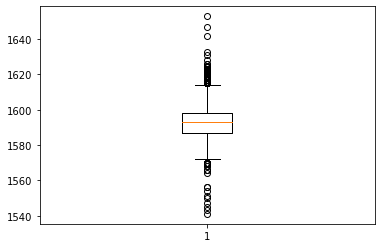

In [229]:
plt.boxplot(data_temp_arc[['temp' ]])
plt.show()

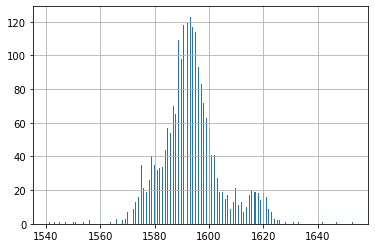

In [230]:
data_temp_arc['temp' ].hist(bins = 300);

Из графиков можно сделать выводы, что данные сгруппированы в пределах от 1560 до 1630 градусов. Вычистим из таблицы эти данные

In [231]:
data_temp_arc = data_temp_arc.query('temp > 1560 and temp < 1630')
print('Размер data_temp_arc  ', data_temp_arc.shape)

Размер data_temp_arc   (2194, 29)


Потеряли 14 строк. Теперь начальная температура

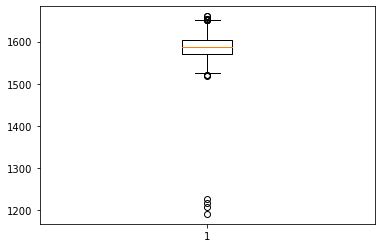

In [232]:
plt.boxplot(data_temp_arc[['temp_init' ]])
plt.show()

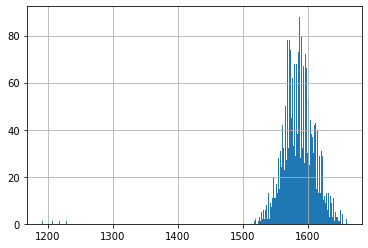

In [233]:
data_temp_arc['temp_init' ].hist(bins = 300);

Просто неприлично. Несколько значений выбились в очень низкий диапазон. Просто удалим их.

In [234]:
data_temp_arc = data_temp_arc.query('temp_init > 1400')
print('Размер data_temp_arc  ', data_temp_arc.shape)

Размер data_temp_arc   (2190, 29)


Потеряли еще 4 строки. Теперь энергетика

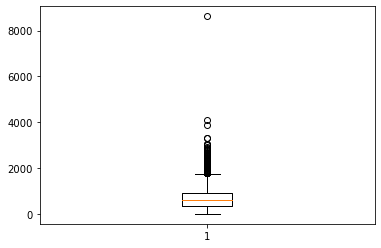

In [235]:
plt.boxplot(data_temp_arc[['energy' ]])
plt.show()

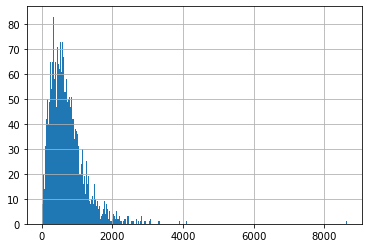

In [236]:
data_temp_arc['energy' ].hist(bins = 300);

Все, что за 3500, можно считать выбросами

In [237]:
data_temp_arc = data_temp_arc.query('energy < 3500')
print('Размер data_temp_arc  ', data_temp_arc.shape)

Размер data_temp_arc   (2187, 29)


Потеряли 3 строки

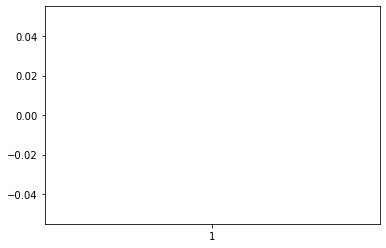

In [238]:
plt.boxplot(data_temp_arc['gas'])
plt.show()

<AxesSubplot:>

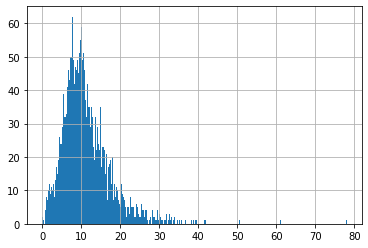

In [239]:
data_temp_arc['gas' ].hist(bins = 300)

За выброс будем считать все, что выше 40 единиц

In [240]:
data_temp_arc = data_temp_arc.query('gas < 40')
print('Размер data_temp_arc  ', data_temp_arc.shape)

Размер data_temp_arc   (2181, 29)


Потеряли еще шесть строк

### Добавки по Bulk


Теперь добавки Bulk

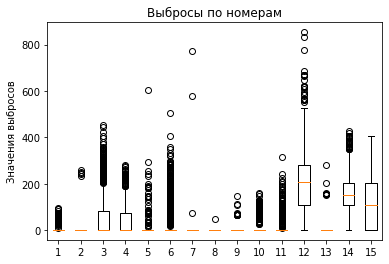

In [241]:
data_temp_arc.columns =[column.replace(" ", "_") for column in data_temp_arc.columns] # поправим имена
plt.boxplot(data_temp_arc[['Bulk_1', 'Bulk_2', 'Bulk_3','Bulk_4', 'Bulk_5','Bulk_6','Bulk_7','Bulk_8','Bulk_9'
                           ,'Bulk_10','Bulk_11','Bulk_12','Bulk_13','Bulk_14','Bulk_15']])
plt.ylabel('Значения выбросов')
plt.title("Выбросы по номерам")
plt.show() 

Некрасиво получается. Посмотрим подробнее. При рассмотрении отсечем нулевые значения

Выброс  Bulk_1
Выбросов  Bulk_1 5


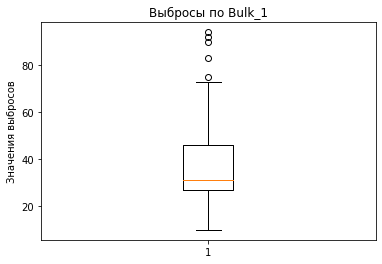

Выброс  Bulk_2
Выбросов  Bulk_2 0


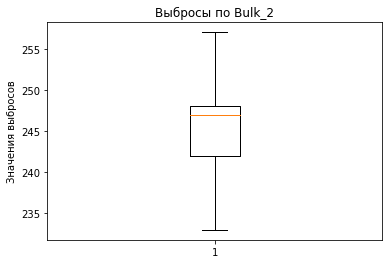

Выброс  Bulk_3
Выбросов  Bulk_3 30


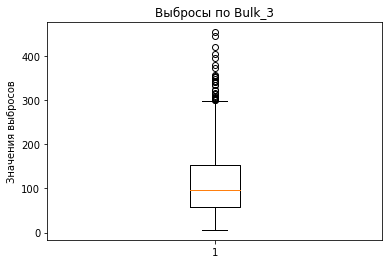

Выброс  Bulk_4
Выбросов  Bulk_4 13


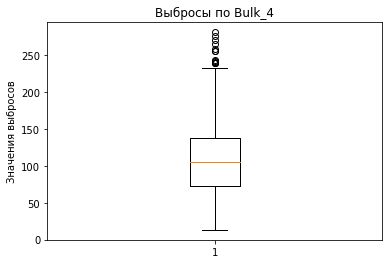

Выброс  Bulk_5
Выбросов  Bulk_5 1


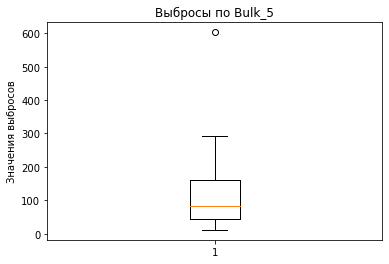

Выброс  Bulk_6
Выбросов  Bulk_6 14


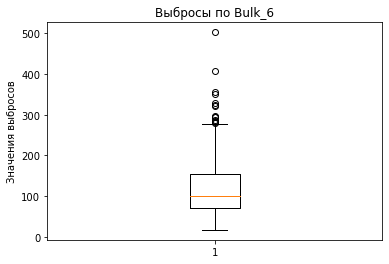

Выброс  Bulk_7
Выбросов  Bulk_7 0


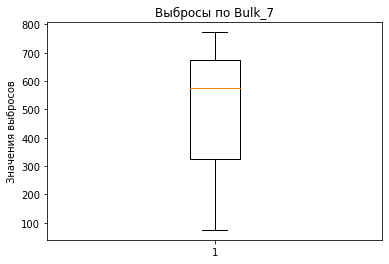

Выброс  Bulk_8
Выбросов  Bulk_8 0


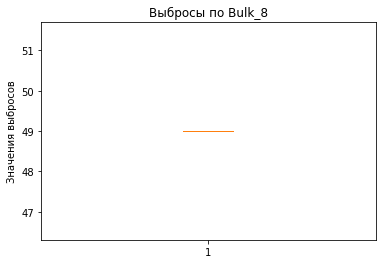

Выброс  Bulk_9
Выбросов  Bulk_9 3


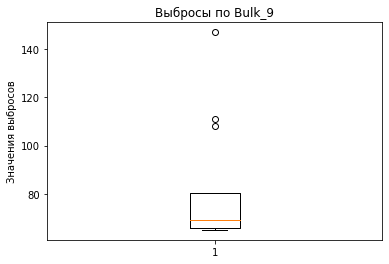

Выброс  Bulk_10
Выбросов  Bulk_10 0


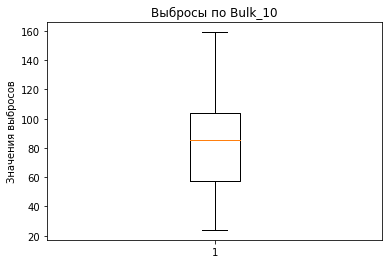

Выброс  Bulk_11
Выбросов  Bulk_11 2


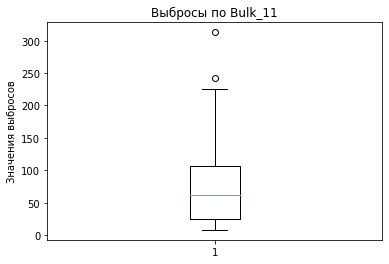

Выброс  Bulk_12
Выбросов  Bulk_12 20


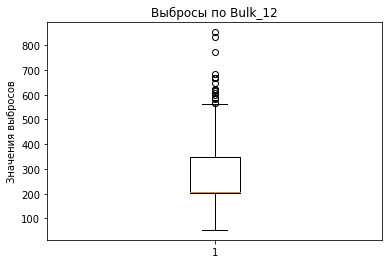

Выброс  Bulk_13
Выбросов  Bulk_13 2


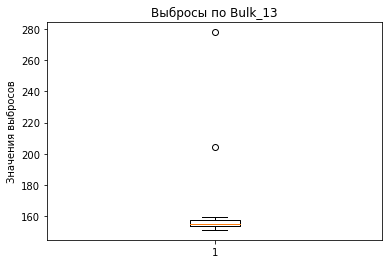

Выброс  Bulk_14
Выбросов  Bulk_14 34


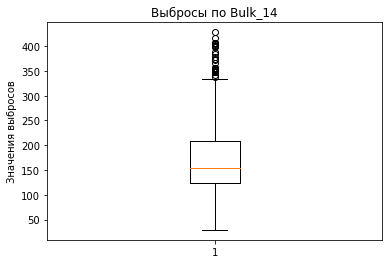

Выброс  Bulk_15
Выбросов  Bulk_15 1


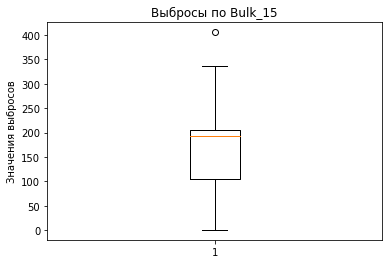

Всего выбросов  125


In [242]:
init_str = 'Bulk_'
a = 1
away = 0

for i in range(1,16):
    
    str_i = init_str+str(i)
    print('Выброс ', str_i)
    boxplot = plt.boxplot(data_temp_arc[str_i].loc[(data_temp_arc[str_i] > 0)])
    plt.ylabel('Значения выбросов')
    plt.title("Выбросы по "+str_i)
    away = away + len(boxplot["fliers"][0].get_data()[1])
    print('Выбросов ', str_i, len(boxplot["fliers"][0].get_data()[1]) )
    plt.show() 
    
print('Всего выбросов ', away)


Всего, за исключением ноля, выбросов за пределы трех квартилей 128. Жалко их выбрасывать. Установим вместо них среднее значение. 

In [243]:
init_str = 'Bulk_'
for i in range(1,16):
    str_i = init_str+str(i)
    border1 = data_temp_arc[str_i].loc[(data_temp_arc[str_i] > 0)].quantile(0.05)
    border2 = data_temp_arc[str_i].loc[(data_temp_arc[str_i] > 0)].quantile(0.95)
    border_m = data_temp_arc[str_i].loc[(data_temp_arc[str_i] > 0)].quantile(0.5)
    
    data_temp_arc[str_i].loc[((data_temp_arc[str_i] >= border2) |
                         (data_temp_arc[str_i] < border1)) &
                         (data_temp_arc[str_i] > 0)] = border_m
    
    



In [244]:

display(data_temp_arc[['Bulk_1', 'Bulk_2', 'Bulk_3','Bulk_4', 'Bulk_5','Bulk_6','Bulk_7','Bulk_8','Bulk_9'
                           ,'Bulk_10','Bulk_11','Bulk_12','Bulk_13','Bulk_14','Bulk_15']])


,Bulk_1,Bulk_2,Bulk_3,Bulk_4,Bulk_5,Bulk_6,Bulk_7,Bulk_8,Bulk_9,Bulk_10,Bulk_11,Bulk_12,Bulk_13,Bulk_14,Bulk_15
0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2470,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0
2471,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,192.5
2472,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,192.5
2473,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0


И еще раз посмотрим картинку

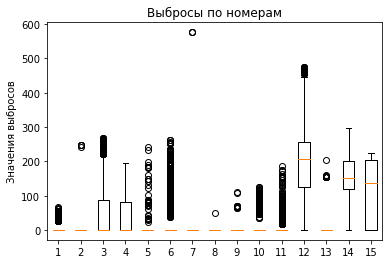

In [245]:
plt.boxplot(data_temp_arc[['Bulk_1', 'Bulk_2', 'Bulk_3','Bulk_4', 'Bulk_5','Bulk_6','Bulk_7','Bulk_8','Bulk_9'
                           ,'Bulk_10','Bulk_11','Bulk_12','Bulk_13','Bulk_14','Bulk_15']])
plt.ylabel('Значения выбросов')
plt.title("Выбросы по номерам")
plt.show() 

Не хороший график по 12 добавке. Посмотрим подробнее

<AxesSubplot:>

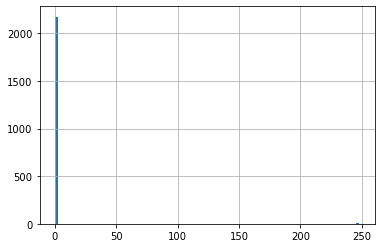

In [246]:
data_temp_arc['Bulk_2' ].hist(bins = 100)

Видно, что он довольно распластаный и возможно, из его напрасно подвергли обработке. Пока оставим так

### Добавки по wire

Будем их рассматривать аналогично Bulk

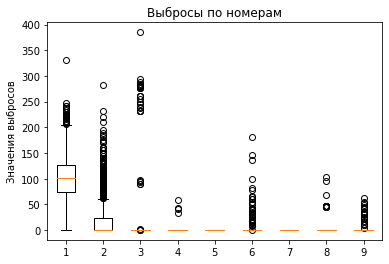

In [247]:
plt.boxplot(data_temp_arc[['Wire_1', 'Wire_2', 'Wire_3','Wire_4', 'Wire_5','Wire_6','Wire_7','Wire_8','Wire_9']])
plt.ylabel('Значения выбросов')
plt.title("Выбросы по номерам")
plt.show() 

Здесь все гораздо лучше, но уж будем следовать схеме

Выброс  Wire_1
Выбросов  Wire_1 30


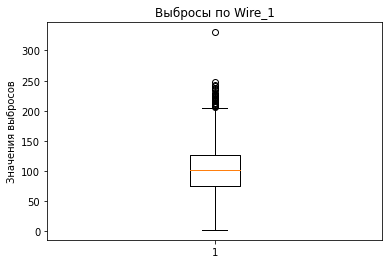

Выброс  Wire_2
Выбросов  Wire_2 23


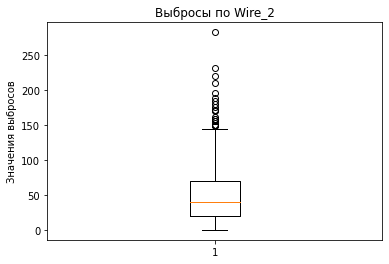

Выброс  Wire_3
Выбросов  Wire_3 3


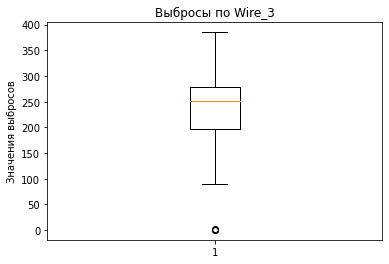

Выброс  Wire_4
Выбросов  Wire_4 0


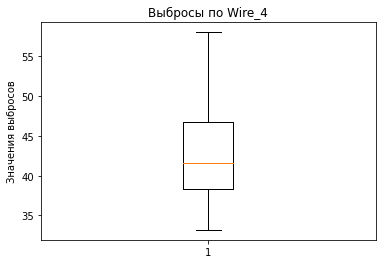

Выброс  Wire_5
Выбросов  Wire_5 0


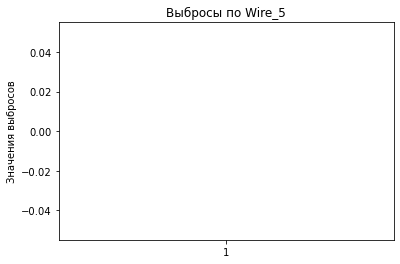

Выброс  Wire_6
Выбросов  Wire_6 3


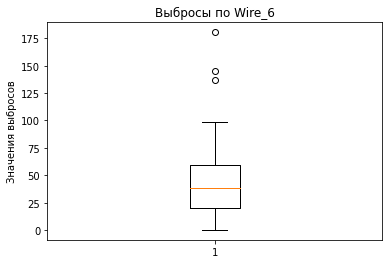

Выброс  Wire_7
Выбросов  Wire_7 0


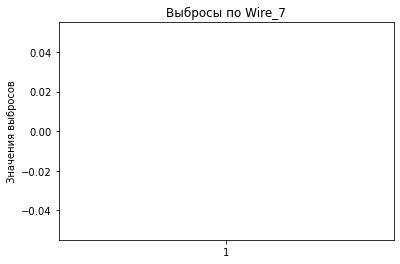

Выброс  Wire_8
Выбросов  Wire_8 3


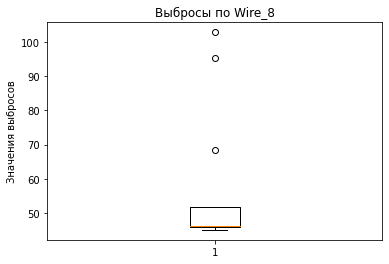

Выброс  Wire_9
Выбросов  Wire_9 0


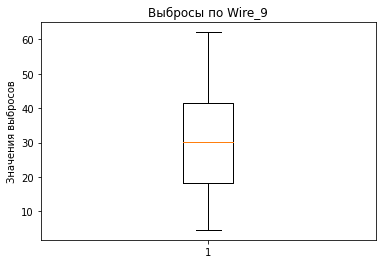

Всего выбросов  62


In [248]:
init_str = 'Wire_'
a = 1
away = 0

for i in range(1,10):
    
    str_i = init_str+str(i)
    print('Выброс ', str_i)
    boxplot = plt.boxplot(data_temp_arc[str_i].loc[(data_temp_arc[str_i] > 0)])
    plt.ylabel('Значения выбросов')
    plt.title("Выбросы по " + str_i)
    away = away + len(boxplot["fliers"][0].get_data()[1])
    print('Выбросов ', str_i, len(boxplot["fliers"][0].get_data()[1]) )
    plt.show() 
    
print('Всего выбросов ', away)



Всего выбросов 45 и сомнения вызывают только 1,3,6,9 позиции посмотрим их подробнее

Выброс  Wire_1


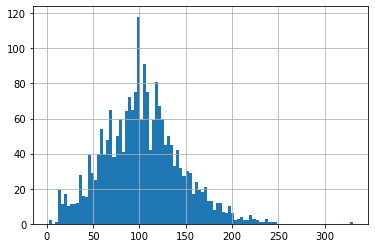

Выброс  Wire_3


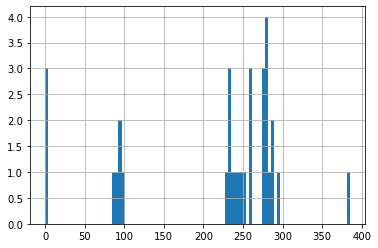

Выброс  Wire_6


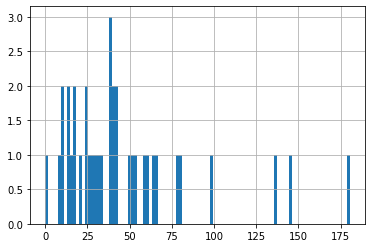

Выброс  Wire_9


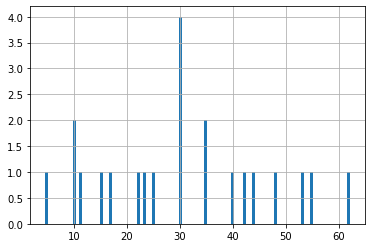

In [249]:
init_str = 'Wire_'
a = 1
away = 0

for i in [1,3,6,9]:
    
    str_i = init_str+str(i)
    print('Выброс ', str_i)
    data_temp_arc[str_i].loc[(data_temp_arc[str_i] > 0)].hist(bins = 100)
    plt.show()
    
    

Данные разбросаны по всей оси, не стоит ничего менять.


## Выводы по подготовке данных


Были считаны и изучены данные. Выполнены следующие работы с ними:
- преобразован формат времени
- Убраны пустые значения

За время работы с данными их количество все время уменьшалось. В зависимости от данных, уменьшение було следущим:
- 3241 исходное количество данных
- 2477 после удаления некорректного времени замера температуры. Во многих данных были только начальные замеры температуры
- 2475 после соединения данных по земерам температуры с данными по энергетики. Двух данных не было.
- 2208 после проверки того, что бы в данных не было никаких изменений после последнего измерения температуры
- 2194 после удаления аномалий по измеренной температуре
- 2191 после удаления аномалий по энергетике
- 2185 после удаления аномалий по газу.

Все аномалии по добавкам были просто заменены на медианное значение.

Итоговая таблица имеет размер

In [250]:
data_temp_arc.shape

(2181, 29)

In [251]:
data_temp_arc.head(3)

,key,temp,energy,temp_init,Wire_1,Wire_2,Wire_3,Wire_4,Wire_5,Wire_6,...,Bulk_7,Bulk_8,Bulk_9,Bulk_10,Bulk_11,Bulk_12,Bulk_13,Bulk_14,Bulk_15,gas
0,1,1613.0,1207.804249,1571.0,60.059998,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986
1,2,1602.0,733.816470,1581.0,96.052315,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561
2,3,1599.0,443.583327,1596.0,91.160157,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793


### Проверка мультиколениарности данных

Для начала проверим признаки на мультиколениарность

In [252]:
# Упростим жизнь и переименуем основной массив
data = data_temp_arc
display(data.corr()) 


,key,temp,energy,temp_init,Wire_1,Wire_2,Wire_3,Wire_4,Wire_5,Wire_6,...,Bulk_7,Bulk_8,Bulk_9,Bulk_10,Bulk_11,Bulk_12,Bulk_13,Bulk_14,Bulk_15,gas
key,1.000000,-0.083301,-0.037400,-0.005255,-0.005343,0.042222,-0.033229,-0.001099,NaN,-0.023516,...,0.028223,0.016016,-0.044882,0.055975,0.043031,0.002270,-0.015649,-0.044597,-0.032300,-0.045201
temp,-0.083301,1.000000,0.301196,0.315189,0.309150,-0.244308,-0.030414,0.055865,NaN,-0.008636,...,0.050669,-0.029199,-0.015424,0.068676,-0.118135,0.271394,-0.021277,0.094913,0.266115,0.079764
energy,-0.037400,0.301196,1.000000,-0.465348,0.005802,0.013370,0.006853,0.017571,NaN,0.045539,...,0.017400,-0.009669,-0.007260,0.009646,0.069852,0.455302,0.020966,0.408805,0.316401,0.285541
temp_init,-0.005255,0.315189,-0.465348,1.000000,0.276913,-0.103049,-0.023069,0.083268,NaN,-0.036543,...,0.036158,-0.012222,-0.023793,0.030377,-0.116592,-0.098398,0.018012,-0.165281,-0.051048,0.025698
Wire_1,-0.005343,0.309150,0.005802,0.276913,1.000000,-0.078819,0.065862,-0.099924,NaN,-0.081138,...,-0.060893,0.036830,0.009970,0.064010,-0.124592,0.145664,0.008606,-0.040468,0.123462,0.150228
Wire_2,0.042222,-0.244308,0.013370,-0.103049,-0.078819,1.000000,0.104129,-0.022289,NaN,-0.053084,...,0.001379,0.019492,0.063685,-0.102346,0.083237,-0.111352,0.006777,0.002525,-0.093675,0.086297
Wire_3,-0.033229,-0.030414,0.006853,-0.023069,0.065862,0.104129,1.000000,0.132739,NaN,0.123440,...,0.077410,-0.002378,-0.008080,-0.027012,-0.022352,-0.102696,-0.008229,0.012428,-0.109932,0.078267
Wire_4,-0.001099,0.055865,0.017571,0.083268,-0.099924,-0.022289,0.132739,1.000000,NaN,0.366234,...,0.635539,-0.000899,-0.003053,-0.010208,-0.008450,-0.063221,-0.003110,-0.092754,-0.062238,0.088893
Wire_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wire_6,-0.023516,-0.008636,0.045539,-0.036543,-0.081138,-0.053084,0.123440,0.366234,NaN,1.000000,...,0.245590,-0.002154,-0.007320,-0.018312,0.003897,-0.011347,-0.007454,0.002502,-0.001045,0.027990


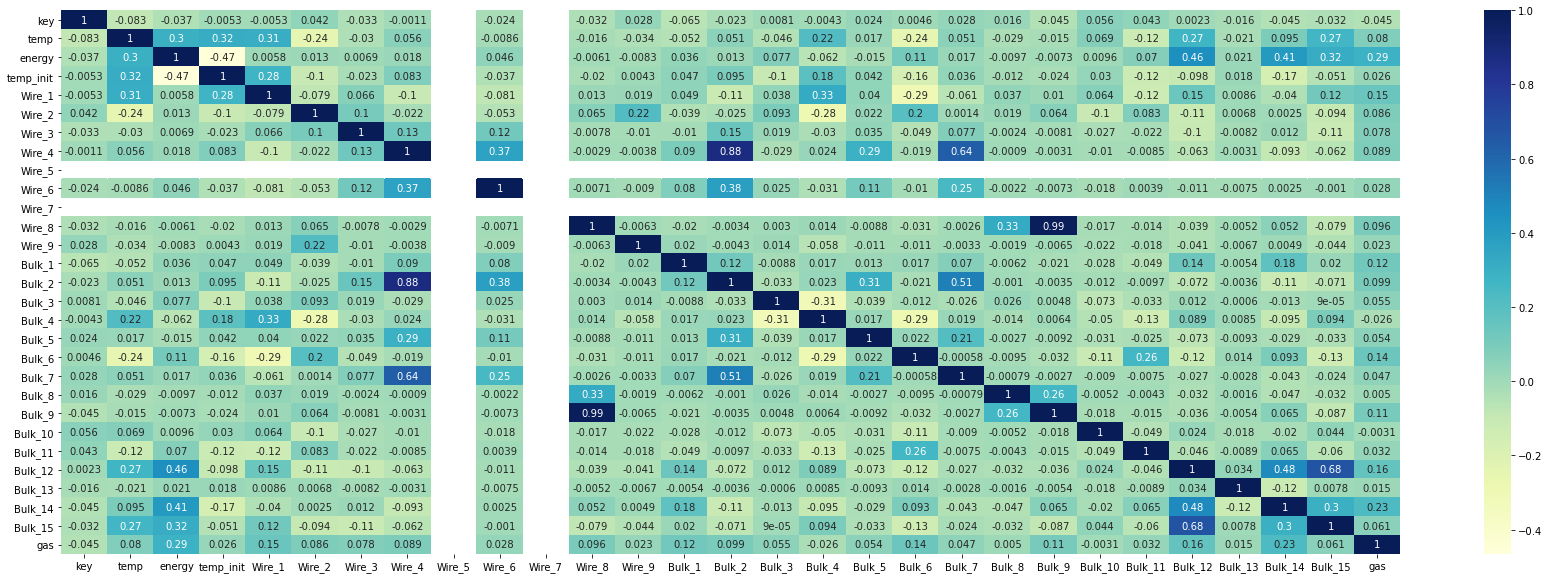

In [253]:
plt.figure(figsize=(30,10)) 
df_plot = sns.heatmap(data.corr(), cmap="YlGnBu", annot=True)  
    
# displaying the heatmap  
plt.show()


In [254]:
X = add_constant(data)  
ds=pd.Series([variance_inflation_factor(X.values, i)   
               for i in range(X.shape[1])],   
              index=X.columns)  
print(ds)


const        31879.968185
key              1.042342
temp             1.879583
energy           2.525569
temp_init        2.030879
Wire_1           1.464577
Wire_2           1.262257
Wire_3           1.097590
Wire_4           5.395401
Wire_5                NaN
Wire_6           1.203820
Wire_7                NaN
Wire_8          55.327194
Wire_9           1.062104
Bulk_1           1.124321
Bulk_2           4.642493
Bulk_3           1.184118
Bulk_4           1.476269
Bulk_5           1.136168
Bulk_6           1.369996
Bulk_7           1.715683
Bulk_8           1.401577
Bulk_9          53.318202
Bulk_10          1.062197
Bulk_11          1.101929
Bulk_12          2.510066
Bulk_13          1.037821
Bulk_14          1.599935
Bulk_15          1.941064
gas              1.270955
dtype: float64


/Users/pavelkrasilcev/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Из результата видно, что у нас пустые данные по Wire_5 и Wire_7. Очень высокая корреляция между Wire_8 и Bulk_9, Bulk_2 и wire_4. Удалим  из них, Bulk_9 и Bulk_2

In [255]:
data.drop(['Wire_5', 'Wire_7', 'Bulk_9', 'Bulk_2'], inplace = True, axis = 1)
data.drop('key',inplace = True, axis = 1)                          # ключевое поле тоже надо убрать
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2181 entries, 0 to 2474
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   temp       2181 non-null   float64
 1   energy     2181 non-null   float64
 2   temp_init  2181 non-null   float64
 3   Wire_1     2181 non-null   float64
 4   Wire_2     2181 non-null   float64
 5   Wire_3     2181 non-null   float64
 6   Wire_4     2181 non-null   float64
 7   Wire_6     2181 non-null   float64
 8   Wire_8     2181 non-null   float64
 9   Wire_9     2181 non-null   float64
 10  Bulk_1     2181 non-null   float64
 11  Bulk_3     2181 non-null   float64
 12  Bulk_4     2181 non-null   float64
 13  Bulk_5     2181 non-null   float64
 14  Bulk_6     2181 non-null   float64
 15  Bulk_7     2181 non-null   float64
 16  Bulk_8     2181 non-null   float64
 17  Bulk_10    2181 non-null   float64
 18  Bulk_11    2181 non-null   float64
 19  Bulk_12    2181 non-null   float64
 20  Bulk_13 

,temp,energy,temp_init,Wire_1,Wire_2,Wire_3,Wire_4,Wire_6,Wire_8,Wire_9,...,Bulk_6,Bulk_7,Bulk_8,Bulk_10,Bulk_11,Bulk_12,Bulk_13,Bulk_14,Bulk_15,gas
temp,1.000000,0.301196,0.315189,0.309150,-0.244308,-0.030414,0.055865,-0.008636,-0.015790,-0.034336,...,-0.244069,0.050669,-0.029199,0.068676,-0.118135,0.271394,-0.021277,0.094913,0.266115,0.079764
energy,0.301196,1.000000,-0.465348,0.005802,0.013370,0.006853,0.017571,0.045539,-0.006088,-0.008281,...,0.109852,0.017400,-0.009669,0.009646,0.069852,0.455302,0.020966,0.408805,0.316401,0.285541
temp_init,0.315189,-0.465348,1.000000,0.276913,-0.103049,-0.023069,0.083268,-0.036543,-0.020471,0.004323,...,-0.157498,0.036158,-0.012222,0.030377,-0.116592,-0.098398,0.018012,-0.165281,-0.051048,0.025698
Wire_1,0.309150,0.005802,0.276913,1.000000,-0.078819,0.065862,-0.099924,-0.081138,0.012743,0.019012,...,-0.293689,-0.060893,0.036830,0.064010,-0.124592,0.145664,0.008606,-0.040468,0.123462,0.150228
Wire_2,-0.244308,0.013370,-0.103049,-0.078819,1.000000,0.104129,-0.022289,-0.053084,0.064864,0.216824,...,0.203795,0.001379,0.019492,-0.102346,0.083237,-0.111352,0.006777,0.002525,-0.093675,0.086297
Wire_3,-0.030414,0.006853,-0.023069,0.065862,0.104129,1.000000,0.132739,0.123440,-0.007784,-0.009986,...,-0.048946,0.077410,-0.002378,-0.027012,-0.022352,-0.102696,-0.008229,0.012428,-0.109932,0.078267
Wire_4,0.055865,0.017571,0.083268,-0.099924,-0.022289,0.132739,1.000000,0.366234,-0.002942,-0.003774,...,-0.018518,0.635539,-0.000899,-0.010208,-0.008450,-0.063221,-0.003110,-0.092754,-0.062238,0.088893
Wire_6,-0.008636,0.045539,-0.036543,-0.081138,-0.053084,0.123440,0.366234,1.000000,-0.007051,-0.009046,...,-0.010211,0.245590,-0.002154,-0.018312,0.003897,-0.011347,-0.007454,0.002502,-0.001045,0.027990
Wire_8,-0.015790,-0.006088,-0.020471,0.012743,0.064864,-0.007784,-0.002942,-0.007051,1.000000,-0.006304,...,-0.030935,-0.002602,0.328793,-0.017053,-0.014117,-0.039257,-0.005195,0.051800,-0.079139,0.096470
Wire_9,-0.034336,-0.008281,0.004323,0.019012,0.216824,-0.009986,-0.003774,-0.009046,-0.006304,1.000000,...,-0.011051,-0.003338,-0.001926,-0.021878,-0.018112,-0.041081,-0.006665,0.004948,-0.043548,0.022750


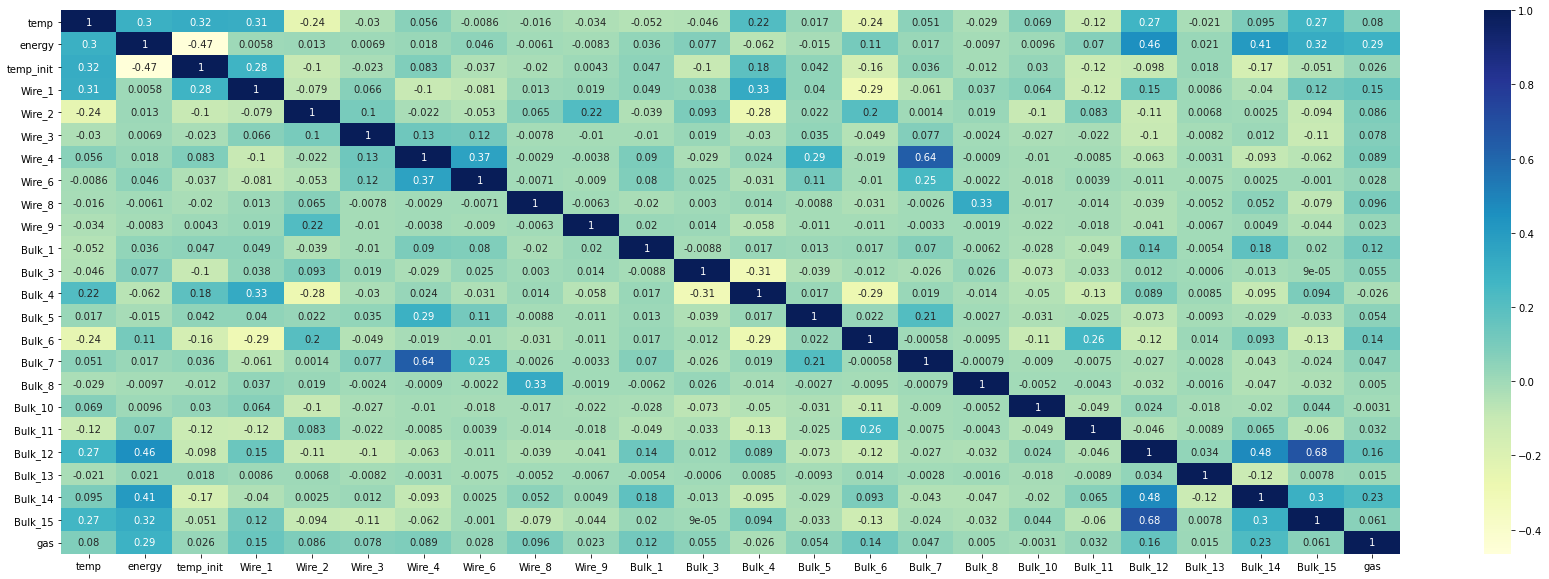

In [256]:
data = data_temp_arc
display(data.corr()) 
plt.figure(figsize=(30,10)) 
df_plot = sns.heatmap(data.corr(), cmap="YlGnBu", annot=True)  

plt.show()

In [257]:
X = add_constant(data)  
ds=pd.Series([variance_inflation_factor(X.values, i)   
               for i in range(X.shape[1])],   
              index=X.columns)  
print(ds)

const        31572.181327
temp             1.865647
energy           2.507796
temp_init        2.014445
Wire_1           1.446413
Wire_2           1.260704
Wire_3           1.089598
Wire_4           2.017942
Wire_6           1.184882
Wire_8           1.167094
Wire_9           1.061474
Bulk_1           1.104921
Bulk_3           1.183701
Bulk_4           1.469188
Bulk_5           1.117482
Bulk_6           1.367069
Bulk_7           1.687908
Bulk_8           1.132959
Bulk_10          1.057584
Bulk_11          1.099843
Bulk_12          2.489430
Bulk_13          1.036833
Bulk_14          1.578291
Bulk_15          1.915927
gas              1.261465
dtype: float64


Из полученных таблиц видно, что данные между собой имеют низкие коэффициенты корреляции. Остался самый высокий между Bulk_2 и wire_4, равный 0.88. С этим согласисмся.


# Построение  и обучение модели

В ходе этого этапа опробуем следующие модели:
- LinearRegression
- CatBoost
- LihtGBM
- RandomForest

Подбор параметров произведем двумя способами: ручным подбором параметров и с использованием метода GridSearchCV. По итогам выберем лучшую модель.


### Подготовка исходных данных для модели

Целевым признаком для обучения модели у нас будет значение конечной температуры temp. Остальные данные относятся к признакам.

Разделим данные на тренировочные, валидационные и тестовые.

In [258]:
target = data['temp']                    # целевой признак
features = data.drop('temp', axis = 1)   # признаки

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size = 0.4, random_state = 12345)   # разделили 60/40

features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size = 0.5, random_state = 12345)   # 40 разделили 20/20

display('Размеры выборок')
print('Признаки тренировочная выборка', features_train.shape, 'целевые признаки', target_train.shape)
print('Признаки валидационная выборка',features_valid.shape, 'целевые признаки', target_valid.shape)
print('Признаки тестовая выборка',features_test.shape, 'целевые признаки', target_test.shape)

'Размеры выборок'

Признаки тренировочная выборка (1308, 23) целевые признаки (1308,)
Признаки валидационная выборка (436, 23) целевые признаки (436,)
Признаки тестовая выборка (437, 23) целевые признаки (437,)


### Модель логистической регрессии

In [259]:
model = LinearRegression()
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
    
mae_metric=mean_absolute_error(target_valid, predicted_valid)
print('Метрика mae по линейной регрессии на валидации', mae_metric)  

predicted_test = model.predict(features_test)   
mae_metric=mean_absolute_error(target_test, predicted_test)
print('Метрика mae по линейной регрессии на тесте', mae_metric)

Метрика mae по линейной регрессии на валидации 6.384728601911626
Метрика mae по линейной регрессии на тесте 6.327926917980099


Модель является самой простейшей и с учетом не очень большого количества данных может быть использована как отправная точка. 

### Модель CatBoost

Для работы с моделью CatBoots воспользуемся ее внутренним типом данных Pool, позволяющем оптимально передать данные в модель. С целью экономии времени используем параметр автоматическогоп прекращения обучения early_stopping_rounds = 5. Оптимизировать будем по параметру глубины depth в предалах от 1 до 16. Также попробуем изменять параметр learning_rate

In [260]:
train_dataset = Pool(data=features_train,
                     label=target_train)

eval_dataset = Pool(data=features_valid,
                    label=target_valid)



best_result_cat = 20000000

for step_depth in range(3, 8):
    model = CatBoostRegressor(iterations=2000, 
                          depth=step_depth, 
                          learning_rate=0.05, 
                          #grow_policy = 'Depthwise',
                          loss_function='RMSE')

    model.fit(train_dataset,
          use_best_model=True,
          eval_set=eval_dataset,
         early_stopping_rounds = 5)# обучаем модель
    print('обучили', step_depth)
    predicted_valid = model.predict(features_valid)
    mae_metric=mean_absolute_error(target_valid, predicted_valid)
    if mae_metric < best_result_cat:
        best_cat_model = model
        best_depth = step_depth
        best_result_cat = mae_metric
    print('На шаге ', step_depth, ' Метрика ', mae_metric)
    


0:	learn: 10.2998571	test: 10.2098391	best: 10.2098391 (0)	total: 872us	remaining: 1.74s
1:	learn: 10.2246749	test: 10.1438784	best: 10.1438784 (1)	total: 1.76ms	remaining: 1.76s
2:	learn: 10.1231601	test: 10.0680731	best: 10.0680731 (2)	total: 2.6ms	remaining: 1.73s
3:	learn: 10.0445368	test: 10.0027613	best: 10.0027613 (3)	total: 3.27ms	remaining: 1.63s
4:	learn: 9.9770197	test: 9.9500576	best: 9.9500576 (4)	total: 4.07ms	remaining: 1.62s
5:	learn: 9.8805510	test: 9.8651483	best: 9.8651483 (5)	total: 4.78ms	remaining: 1.59s
6:	learn: 9.8157945	test: 9.8119390	best: 9.8119390 (6)	total: 5.55ms	remaining: 1.58s
7:	learn: 9.7288807	test: 9.7420046	best: 9.7420046 (7)	total: 6.3ms	remaining: 1.57s
8:	learn: 9.6530306	test: 9.6821328	best: 9.6821328 (8)	total: 7.25ms	remaining: 1.6s
9:	learn: 9.5885431	test: 9.6130131	best: 9.6130131 (9)	total: 8.01ms	remaining: 1.59s
10:	learn: 9.5320522	test: 9.5628392	best: 9.5628392 (10)	total: 8.77ms	remaining: 1.59s
11:	learn: 9.4572860	test: 9.5155

In [261]:
display('Лучшие достигнутые параметры ')
print('На шаге ', best_depth, ' Метрика по валидации ', best_result_cat)

'Лучшие достигнутые параметры '

На шаге  4  Метрика по валидации  6.016321496240846


In [262]:
predicted_test = best_cat_model.predict(features_test)
mae_metric=mean_absolute_error(target_test, predicted_test)
print('Качество модели на тесте ', mae_metric)

Качество модели на тесте  6.229296013896655


### Модель  LihgtGBM

In [263]:
best_result_lgb = 20000000

for step in range(2, 10):
    booster_lgb = lgb.LGBMModel(objective="regression", n_estimators = 500, 
                                #learning_rate=0.1,
                                num_leaves = step, max_depth = 7)

    booster_lgb.fit(features_train,  target_train,  eval_set=[(features_valid, target_valid),], 
                eval_metric="rmse"
                ,early_stopping_rounds= 5) # обучаем модель
    print('обучили')
    predicted_valid = booster_lgb.predict(features_valid)
    mae_metric=mean_absolute_error(target_valid, predicted_valid)
    if mae_metric < best_result_lgb:
        best_lgb_model = booster_lgb
        best_num_leaves = step
        best_result_lgb = mae_metric
    print('На шаге ', step, ' Метрика ', mae_metric)
    


[1]	valid_0's rmse: 10.2392	valid_0's l2: 104.84
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 10.1651	valid_0's l2: 103.329
[3]	valid_0's rmse: 10.1087	valid_0's l2: 102.186
[4]	valid_0's rmse: 10.0709	valid_0's l2: 101.422
[5]	valid_0's rmse: 9.99576	valid_0's l2: 99.9152
[6]	valid_0's rmse: 9.94618	valid_0's l2: 98.9265
[7]	valid_0's rmse: 9.89797	valid_0's l2: 97.9698
[8]	valid_0's rmse: 9.86276	valid_0's l2: 97.2741
[9]	valid_0's rmse: 9.7977	valid_0's l2: 95.9949
[10]	valid_0's rmse: 9.7428	valid_0's l2: 94.9221
[11]	valid_0's rmse: 9.6926	valid_0's l2: 93.9466
[12]	valid_0's rmse: 9.6635	valid_0's l2: 93.3831
[13]	valid_0's rmse: 9.61772	valid_0's l2: 92.5005
[14]	valid_0's rmse: 9.57381	valid_0's l2: 91.6579
[15]	valid_0's rmse: 9.52985	valid_0's l2: 90.818
[16]	valid_0's rmse: 9.49609	valid_0's l2: 90.1758
[17]	valid_0's rmse: 9.45466	valid_0's l2: 89.3906
[18]	valid_0's rmse: 9.43078	valid_0's l2: 88.9396
[19]	valid_0's rmse: 9.38953	valid_0'

In [264]:
print('Лучшая метрика на валидации', best_result_lgb)
test_preds = booster_lgb.predict(features_test)
display('Оценка модели на тесте', mean_absolute_error(test_preds, target_test))
print('Параметры модели, листьев', best_num_leaves)

Лучшая метрика на валидации 6.03860158948725


'Оценка модели на тесте'

6.12288531263092

Параметры модели, листьев 4


### Модель LightGBM  с подбором параметров GridSeach

Переделим по новой массив данных на тренировочный и тестовый

In [265]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size = 0.2, random_state = 12345)   # разделили 80/20




In [266]:
params_test1={'max_depth': range(2,8,1), 'num_leaves':range(2, 10, 1)}
              
gsearch1 = GridSearchCV(estimator = lgb.LGBMRegressor(objective="regression", n_estimators = 500, 
                                 metrics='mae', learning_rate=0.1), param_grid = params_test1, 
                                 cv=5, verbose = 2)
                                
gsearch1.fit(features_train,  target_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END ..........................max_depth=2, num_leaves=2; total time=   0.1s
[CV] END ..........................max_depth=2, num_leaves=2; total time=   0.2s
[CV] END ..........................max_depth=2, num_leaves=2; total time=   0.2s
[CV] END ..........................max_depth=2, num_leaves=2; total time=   0.3s
[CV] END ..........................max_depth=2, num_leaves=2; total time=   0.1s
[CV] END ..........................max_depth=2, num_leaves=3; total time=   0.1s
[CV] END ..........................max_depth=2, num_leaves=3; total time=   0.1s
[CV] END ..........................max_depth=2, num_leaves=3; total time=   0.1s
[CV] END ..........................max_depth=2, num_leaves=3; total time=   0.1s
[CV] END ..........................max_depth=2, num_leaves=3; total time=   0.2s
[CV] END ..........................max_depth=2, num_leaves=4; total time=   0.1s
[CV] END ..........................max_depth=2,

GridSearchCV(cv=5,
             estimator=LGBMRegressor(metrics='mae', n_estimators=500,
                                     objective='regression'),
             param_grid={'max_depth': range(2, 8), 'num_leaves': range(2, 10)},
             verbose=2)

In [267]:
print(gsearch1.best_params_)

#predicted_valid = gsearch1.predict(features_valid)
#mae_metric=mean_absolute_error(target_valid, predicted_valid)
print('Лучшая метрика на валидации', gsearch1.best_score_)
test_preds = gsearch1.predict(features_test)
display('Оценка модели на тесте', mean_absolute_error(test_preds, target_test))

{'max_depth': 2, 'num_leaves': 2}
Лучшая метрика на валидации 0.47432219351363125


'Оценка модели на тесте'

6.533663788415882

### Модель RandomForest  с подбором параметров GridSeach

In [268]:

parametrs = { 'n_estimators': range (15, 25, 1),
              'max_depth': range (5,12, 1)}

gsearch2 = GridSearchCV(estimator = RandomForestRegressor(random_state=12345 ),param_grid = parametrs,
                        scoring='neg_mean_absolute_error',
                                 cv=5, verbose = 3)
    
    #forest_reg = RandomForestRegressor()
#grid_search = GridSearchCV(forest_reg, parametrs, cv=5,
                           #scoring='mean_squared_error', verbose = 3)
gsearch2.fit(features_train,  target_train)



Fitting 5 folds for each of 70 candidates, totalling 350 fits
[CV 1/5] END ...................max_depth=5, n_estimators=15; total time=   0.1s
[CV 2/5] END ...................max_depth=5, n_estimators=15; total time=   0.1s
[CV 3/5] END ...................max_depth=5, n_estimators=15; total time=   0.1s
[CV 4/5] END ...................max_depth=5, n_estimators=15; total time=   0.1s
[CV 5/5] END ...................max_depth=5, n_estimators=15; total time=   0.1s
[CV 1/5] END ...................max_depth=5, n_estimators=16; total time=   0.1s
[CV 2/5] END ...................max_depth=5, n_estimators=16; total time=   0.1s
[CV 3/5] END ...................max_depth=5, n_estimators=16; total time=   0.1s
[CV 4/5] END ...................max_depth=5, n_estimators=16; total time=   0.1s
[CV 5/5] END ...................max_depth=5, n_estimators=16; total time=   0.1s
[CV 1/5] END ...................max_depth=5, n_estimators=17; total time=   0.1s
[CV 2/5] END ...................max_depth=5, n_

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=12345),
             param_grid={'max_depth': range(5, 12),
                         'n_estimators': range(15, 25)},
             scoring='neg_mean_absolute_error', verbose=3)

In [269]:
print(gsearch2.best_params_)

#predicted_valid = gsearch1.predict(features_valid)
#mae_metric=mean_absolute_error(target_valid, predicted_valid)
print('Лучшая метрика на валидации', -gsearch2.best_score_)
test_preds = gsearch2.predict(features_test)
display('Оценка модели на тесте', mean_absolute_error(test_preds, target_test))

{'max_depth': 10, 'n_estimators': 24}
Лучшая метрика на валидации 5.870449826225125


'Оценка модели на тесте'

6.523996414746182

## Подбор параметров модели на нормализованном массиве

In [270]:
from sklearn.preprocessing import StandardScaler
pd.options.mode.chained_assignment = None

numeric = ['Bulk_1', 'Bulk_3','Bulk_4', 'Bulk_5','Bulk_6','Bulk_7','Bulk_8'
                           ,'Bulk_10','Bulk_11','Bulk_12','Bulk_13','Bulk_14','Bulk_15',
          'Wire_1', 'Wire_2', 'Wire_3','Wire_4','Wire_6','Wire_8','Wire_9',
          'gas','temp_init', 'energy']




scaler = StandardScaler()
scaler.fit(features[numeric])
features[numeric] = scaler.transform(features[numeric])


features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size = 0.4, random_state = 12345)   # разделили 60/40

features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size = 0.5, random_state = 12345)   # 40 разделили 20/20

display('Размеры выборок')
print('Признаки тренировочная выборка', features_train.shape, 'целевые признаки', target_train.shape)
print('Признаки валидационная выборка',features_valid.shape, 'целевые признаки', target_valid.shape)
print('Признаки тестовая выборка',features_test.shape, 'целевые признаки', target_test.shape)


# линейная регрессия

model = LinearRegression()
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)
    
mae_metric=mean_absolute_error(target_test, predicted_test)
print('Метрика mae по линейной регрессии ', mae_metric)    



'Размеры выборок'

Признаки тренировочная выборка (1308, 23) целевые признаки (1308,)
Признаки валидационная выборка (436, 23) целевые признаки (436,)
Признаки тестовая выборка (437, 23) целевые признаки (437,)
Метрика mae по линейной регрессии  6.327926917980102


### Нормализованный CAtBoost с ручным подбором

In [271]:
train_dataset = Pool(data=features_train,
                     label=target_train)

eval_dataset = Pool(data=features_valid,
                    label=target_valid)

#model = CatBoostRegressor(iterations=200, 
#                          depth=16, 
#                          learning_rate=0.1, 
#                          loss_function='MAE')


best_result_cat = 20000000

for step_depth in range(3, 8):
    model = CatBoostRegressor(iterations=2000, 
                          depth=step_depth, 
                          learning_rate=0.05, 
                          #grow_policy = 'Depthwise',
                          loss_function='RMSE')

    model.fit(train_dataset,
          use_best_model=True,
          eval_set=eval_dataset,
         early_stopping_rounds = 5)# обучаем модель
    print('обучили', step_depth)
    predicted_valid = model.predict(features_valid)
    mae_metric=mean_absolute_error(target_valid, predicted_valid)
    if mae_metric < best_result_cat:
        best_cat_model = model
        best_depth = step_depth
        best_result_cat = mae_metric
    print('На шаге ', step_depth, ' Метрика ', mae_metric)
    

0:	learn: 10.2998571	test: 10.2098391	best: 10.2098391 (0)	total: 744us	remaining: 1.49s
1:	learn: 10.2246749	test: 10.1438784	best: 10.1438784 (1)	total: 1.68ms	remaining: 1.67s
2:	learn: 10.1231601	test: 10.0680731	best: 10.0680731 (2)	total: 2.4ms	remaining: 1.6s
3:	learn: 10.0443656	test: 10.0026243	best: 10.0026243 (3)	total: 3.18ms	remaining: 1.59s
4:	learn: 9.9768528	test: 9.9499258	best: 9.9499258 (4)	total: 3.98ms	remaining: 1.59s
5:	learn: 9.8803927	test: 9.8650218	best: 9.8650218 (5)	total: 4.8ms	remaining: 1.59s
6:	learn: 9.8156395	test: 9.8118177	best: 9.8118177 (6)	total: 5.56ms	remaining: 1.58s
7:	learn: 9.7287256	test: 9.7418881	best: 9.7418881 (7)	total: 6.5ms	remaining: 1.62s
8:	learn: 9.6528776	test: 9.6820204	best: 9.6820204 (8)	total: 7.29ms	remaining: 1.61s
9:	learn: 9.5883890	test: 9.6129019	best: 9.6129019 (9)	total: 8.2ms	remaining: 1.63s
10:	learn: 9.5318976	test: 9.5627303	best: 9.5627303 (10)	total: 9.11ms	remaining: 1.65s
11:	learn: 9.4571177	test: 9.515456

In [272]:
display('Лучшие достигнутые параметры ')
print('На шаге ', best_depth, ' Метрика ', best_result_cat)
predicted_test = best_cat_model.predict(features_test)
mae_metric=mean_absolute_error(target_test, predicted_test)
print('Качество модели на тесте ', mae_metric)

'Лучшие достигнутые параметры '

На шаге  6  Метрика  6.0408916773589425
Качество модели на тесте  6.255032760620743


In [273]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size = 0.2, random_state = 12345)   # разделили 80/20



### Нормализованный LightGBM совместно с GridSearch

In [274]:
params_test1={'max_depth': range(2,8,1), 'num_leaves':range(2, 10, 1)}
              
gsearch1 = GridSearchCV(estimator = lgb.LGBMRegressor(objective="regression", n_estimators = 500, 
                                 metrics='mae', learning_rate=0.1), param_grid = params_test1, 
                                 cv=5, verbose = 2)
                                

gsearch1.fit(features_train,  target_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END ..........................max_depth=2, num_leaves=2; total time=   0.1s
[CV] END ..........................max_depth=2, num_leaves=2; total time=   0.1s
[CV] END ..........................max_depth=2, num_leaves=2; total time=   0.1s
[CV] END ..........................max_depth=2, num_leaves=2; total time=   0.1s
[CV] END ..........................max_depth=2, num_leaves=2; total time=   0.1s
[CV] END ..........................max_depth=2, num_leaves=3; total time=   0.1s
[CV] END ..........................max_depth=2, num_leaves=3; total time=   0.3s
[CV] END ..........................max_depth=2, num_leaves=3; total time=   0.3s
[CV] END ..........................max_depth=2, num_leaves=3; total time=   0.2s
[CV] END ..........................max_depth=2, num_leaves=3; total time=   0.3s
[CV] END ..........................max_depth=2, num_leaves=4; total time=   0.4s
[CV] END ..........................max_depth=2,

GridSearchCV(cv=5,
             estimator=LGBMRegressor(metrics='mae', n_estimators=500,
                                     objective='regression'),
             param_grid={'max_depth': range(2, 8), 'num_leaves': range(2, 10)},
             verbose=2)

In [275]:
print(gsearch1.best_params_)

#predicted_valid = gsearch1.predict(features_valid)
#mae_metric=mean_absolute_error(target_valid, predicted_valid)
print('Лучшая метрика на валидации', gsearch1.best_score_)
test_preds = gsearch1.predict(features_test)
display('Оценка модели на тесте', mean_absolute_error(test_preds, target_test))

{'max_depth': 2, 'num_leaves': 2}
Лучшая метрика на валидации 0.474805853232141


'Оценка модели на тесте'

6.5478987334523895

### Вывод по работе с нормализованными данными

Нормализация ничего не добавляет к результатам. Они точно такие же, как и на не нормализованных массивах.

### Проверка на важность признаков.

Во всем наборе использованных моделей и методов обучения лучший результат показала модель LightGBM. Проверим эту модель на важность признаков.

array([66, 60, 17, 14,  0,  0,  0,  0,  0, 15,  7,  4,  0, 10,  0,  0,  0,
        5,  3,  0, 10, 10, 13], dtype=int32)

,Features,Importances
8,Wire_9,0
14,Bulk_7,0
12,Bulk_5,0
15,Bulk_8,0
7,Wire_8,0
6,Wire_6,0
16,Bulk_10,0
4,Wire_3,0
19,Bulk_13,0
5,Wire_4,0


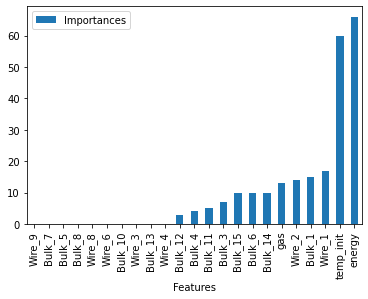

In [276]:
importances = best_lgb_model.feature_importances_
display(importances)
final_df = pd.DataFrame({"Features" : pd.DataFrame(features_train).columns, "Importances" : importances})
final_df.set_index('Importances')

# Сортируем их по возрастанию для лучшей визуализации
final_df = final_df.sort_values('Importances')
display(final_df)
final_df.set_index('Features').plot(kind= 'bar')
plt.show()


Как можно видеть, ряд признаков не оказывают никакого влияния на модель. Удалим эти признаки и снова получим лучшую модель.

In [277]:
data.drop(['Wire_9', 'Wire_8','Wire_6','Wire_3','Wire_4',
          'Bulk_7', 'Bulk_5', 'Bulk_8', 'Bulk_10', 'Bulk_13'], inplace = True, axis = 1)
target = data['temp']                    # целевой признак
features = data.drop('temp', axis = 1)   # признаки

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size = 0.4, random_state = 12345)   # разделили 60/40

features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size = 0.5, random_state = 12345)   # 40 разделили 20/20
display(data.head())
display('Размеры выборок')
print('Признаки тренировочная выборка', features_train.shape, 'целевые признаки', target_train.shape)
print('Признаки валидационная выборка',features_valid.shape, 'целевые признаки', target_valid.shape)
print('Признаки тестовая выборка',features_test.shape, 'целевые признаки', target_test.shape)
data.info()


,temp,energy,temp_init,Wire_1,Wire_2,Bulk_1,Bulk_3,Bulk_4,Bulk_6,Bulk_11,Bulk_12,Bulk_14,Bulk_15,gas
0,1613.0,1207.804249,1571.0,60.059998,0.00000,0.0,0.0,43.0,0.0,0.0,206.0,150.0,154.0,29.749986
1,1602.0,733.816470,1581.0,96.052315,0.00000,0.0,0.0,73.0,0.0,0.0,206.0,149.0,154.0,12.555561
2,1599.0,443.583327,1596.0,91.160157,0.00000,0.0,0.0,34.0,0.0,0.0,205.0,152.0,153.0,28.554793
3,1625.0,670.663327,1601.0,89.063515,0.00000,0.0,0.0,81.0,0.0,0.0,207.0,153.0,154.0,18.841219
4,1602.0,997.496095,1576.0,89.238236,9.11456,0.0,0.0,78.0,0.0,0.0,203.0,151.0,152.0,5.413692


'Размеры выборок'

Признаки тренировочная выборка (1308, 13) целевые признаки (1308,)
Признаки валидационная выборка (436, 13) целевые признаки (436,)
Признаки тестовая выборка (437, 13) целевые признаки (437,)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2181 entries, 0 to 2474
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   temp       2181 non-null   float64
 1   energy     2181 non-null   float64
 2   temp_init  2181 non-null   float64
 3   Wire_1     2181 non-null   float64
 4   Wire_2     2181 non-null   float64
 5   Bulk_1     2181 non-null   float64
 6   Bulk_3     2181 non-null   float64
 7   Bulk_4     2181 non-null   float64
 8   Bulk_6     2181 non-null   float64
 9   Bulk_11    2181 non-null   float64
 10  Bulk_12    2181 non-null   float64
 11  Bulk_14    2181 non-null   float64
 12  Bulk_15    2181 non-null   float64
 13  gas        2181 non-null   float64
dtypes: float64(14)
memory usage: 255.6 KB


In [278]:
best_result_lgb = 20000000

for step in range(2, 10):
    booster_lgb = lgb.LGBMModel(objective="regression", n_estimators = 500, 
                                #learning_rate=0.1,
                                num_leaves = step, max_depth = 7)

    booster_lgb.fit(features_train,  target_train,  eval_set=[(features_valid, target_valid),], 
                eval_metric="rmse"
                ,early_stopping_rounds= 5) # обучаем модель
    print('обучили')
    predicted_valid = booster_lgb.predict(features_valid)
    mae_metric=mean_absolute_error(target_valid, predicted_valid)
    if mae_metric < best_result_lgb:
        best_lgb_model = booster_lgb
        best_num_leaves = step
        best_result_lgb = mae_metric
    print('На шаге ', step, ' Метрика ', mae_metric)
    

[1]	valid_0's rmse: 10.2392	valid_0's l2: 104.84
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 10.1651	valid_0's l2: 103.329
[3]	valid_0's rmse: 10.1087	valid_0's l2: 102.186
[4]	valid_0's rmse: 10.0709	valid_0's l2: 101.422
[5]	valid_0's rmse: 9.99576	valid_0's l2: 99.9152
[6]	valid_0's rmse: 9.94618	valid_0's l2: 98.9265
[7]	valid_0's rmse: 9.89797	valid_0's l2: 97.9698
[8]	valid_0's rmse: 9.86276	valid_0's l2: 97.2741
[9]	valid_0's rmse: 9.7977	valid_0's l2: 95.9949
[10]	valid_0's rmse: 9.7428	valid_0's l2: 94.9221
[11]	valid_0's rmse: 9.6926	valid_0's l2: 93.9466
[12]	valid_0's rmse: 9.6635	valid_0's l2: 93.3831
[13]	valid_0's rmse: 9.61772	valid_0's l2: 92.5005
[14]	valid_0's rmse: 9.57381	valid_0's l2: 91.6579
[15]	valid_0's rmse: 9.52985	valid_0's l2: 90.818
[16]	valid_0's rmse: 9.49609	valid_0's l2: 90.1758
[17]	valid_0's rmse: 9.45466	valid_0's l2: 89.3906
[18]	valid_0's rmse: 9.43078	valid_0's l2: 88.9396
[19]	valid_0's rmse: 9.38953	valid_0'

In [279]:
print('Лучшая метрика на валидации', best_result_lgb)
test_preds = booster_lgb.predict(features_test)
display('Оценка модели на тесте', mean_absolute_error(test_preds, target_test))
print('Параметры модели, листьев', best_num_leaves)

Лучшая метрика на валидации 6.03860158948725


'Оценка модели на тесте'

6.12288531263092

Параметры модели, листьев 4


# Итоги по проведенной работе

Для выполнения задания были предоставлены данные, накопленные в течении 3241 плавки и содержащие данные по начальной и конечной температуре, энергетике, времени проведения плавки и добавкам.

Необходимо было разработать модель, которая будет предсказывать по имеющимся данных конечную температуру в ковше. 

Данные были изучены и приведены в вид, который стал пригоден для обучения модели. Для этого были сделаны следующие действия:
- проведен анализ времен начала и конца плавок и воздействий в процессе плавок. Все данные с воздействиями, которые лежали за пределами начала и конца плавок были удалены.
- отсутствующие данные по добавкам были установлены в значение ноль.

Целевым признаком для моделирования было принято конечное значение температуры.

Признаки и целевые признаки были изучены на предмет аномальных значений. Также была проверена мультиколениаронсть признаков. По каждому обнаруженному факту принималось отдельное решение по исправлению ситуации.

В Итоге для целей обучения модели в массиве данных осталось 2185 данных.

Для обучения использовались несколько моделей с различными методами поиска оптимальных параметров. Также была сделана попытка улучшить результаты путем нормалтзации признаков. Результаты приведены в таблице.



|Модель|Результат на тестовых данных|
| :---| :---:| 
|Линейная регрессия|6.32|
|CatBoost|6.22|
|LightGBM|6.12|
|LightGBM совместно с GridSearchCV|6.54|
|RandomForest совместно с GridSearchCV|6.52|
|Линейная регрессия с нормализацией|6.32|
|CatBoost с нормализацией|6.22|
|LightGBM совместно с GridSearch с нормализацией|6.54|


Изучение приведенной таблицы позволяет сделать следующие выводы:
- ручной подбор параметров дает более высокие результаты на тестовой выборке, чем использование оптимизатора GridSearch
- нормализация данных ничего не прибавила к результаты и ее использование в данной ситуации не целесообразно.

Наилучные показатели на тестовых данных получились у модели LihtGBM  с ручным подбором параметров. Метрика MAE на тестовом наборе  6.12

Дополнительно для этой модели была проведена проверка важности признаков. Было установлено, что 10 признаков имеют нулевую важность. Эти признаки были удалены и модель прошла тернировку еще раз. Значения качества не изменились.

Таким образом можно сказать, что из всего множества параметров, предоставленных заказчиком, на конечный результат влияют всего 13 признаков, приведенные в порядке уменьшения значимости: энергия приложенная, начальная температура, добавки Wire_1, Bulk_1, Wire_2, gas, Bulk_14, Bulk_6, Bulk_1, Bulk_15, Bulk_3, Bulk_11, Bulk_4, Bulk_12.